# Context



## Datasaet

### NYC
Article:

https://javilopezcastillo.medium.com/multiple-linear-regression-analysis-of-citi-bike-ridership-data-c49fd3f211f7


Dataset:
https://citibikenyc.com/system-data

https://citibikenyc.com/system-data/operating-reports


https://s3.amazonaws.com/tripdata/index.html


Chicago

https://divvybikes.com/system-data

https://divvy-tripdata.s3.amazonaws.com/index.html




# Imports

In [5]:
import logging
from typing import Tuple, Dict
from typing_extensions import Annotated
#from haversine import haversine, Unit

import calendar
import holidays
from datetime import date, timedelta

import requests
import os
import glob
import zipfile
import time

import shutil 

import gc
#import duckdb

import json
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds


#import optuna        # HPO
#import mlflow        # Tracking
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
#import xgboost       # Train

import matplotlib.pyplot as plt
import seaborn as sns

# Settings

In [24]:
DATASET_DIR = "../data/datasets"
RAW_WEATHER_DATASET_DIR = f"{DATASET_DIR}/weather/raw/"
RAW_CITIBIKE_DATASET_DIR = f"{DATASET_DIR}/citibike/raw"

In [7]:
!ls -lh {RAW_DATASET_DIR}

total 0


# Download dataset

In [3]:
DATASET_TARGET_COLUMN_NAME = "target"
DATASET_URL = ""

In [ ]:
def data_splitter(
    dataset: pd.DataFrame,
    test_size: float = 0.2,
    shuffle: boo = True,
    random_state: int = 42
) -> Tuple[Annotated[pd.DataFrame, "train"], Annotated[pd.DataFrame, "test"]]: 
    print(f"[data-splitter] dataset: {dataset.shape}")
    train, test = train_test_split(
        dataset,
        test_size=test_size,
        shuffle=shuffle,
        random_state=random_state
    )
    print(f"[data-splitter] train: {train.shape}")
    print(f"[data-splitter] test : {train.shape}")
    return train, test

In [ ]:
# Train model
def train_model(
    dataset: pd.DataFrame,
    params: Dict
):
    model = xgb.XGBRegressor(**params)
    model.fit(X, y)
    print("Train model")

    return model

In [ ]:
# Evaluate model
def evaluate_model(
    model,
    dataset: pd.DataFrame
) -> Tuple[Annotated[float, "r2"], Annotated[float, "rmse"]]:
    try:
        print("Predict")
        X = dataset.drop(columns=[DATASET_TARGET_COLUMN_NAME])
        y_true = dataset[DATASET_TARGET_COLUMN_NAME]
        y_pred = mode.predict(X)

        r2 = r2_score(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)
        
        return r2, rmse
    except Exception as e:
        logging.error("error in evaluation".format(e))
        raise e
    

# Dataset 

In [2]:
#https://s3.amazonaws.com/tripdata/index.html

In [5]:
#!wget https://s3.amazonaws.com/tripdata/202401-citibike-tripdata.zip

In [6]:
#!unzip 202401-citibike-tripdata.zip -d data/202401




## Download trip dataset

In [7]:

def download_zip_file(year_month, output_dir: str):
    # Base URL
    base_url = "https://s3.amazonaws.com/tripdata/"
    
    # Construct the filename
    file_name = f"{year_month}-citibike-tripdata.zip"
    
    # Build the complete URL
    complete_url = base_url + file_name
    
    # Make the HTTP request to download the file
    try:
        response = requests.get(complete_url)
        response.raise_for_status()  # Will raise an exception for HTTP errors
        
        # Save the ZIP file to the local system
        zip_path = os.path.join(output_dir, file_name)
        print(f"{zip_path}")
        with open(zip_path, 'wb') as file:
            file.write(response.content)
        
        print(f"The file {file_name} has been successfully downloaded.")
    
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the file: {e}")


In [13]:
# Import libraries
import glob
import pandas as pd

def read_data(data_dir: str, params: None):
    print("Read data in directory {data_dir}")
    # Get CSV files list from a folder
    #path = './data/202401'
    csv_files = glob.glob(data_dir + "/*.csv")
    
    # Read each CSV file into DataFrame
    # This creates a list of dataframes
    if params:
        df_list = (pd.read_csv(file, **params) for file in csv_files)
    else: 
        df_list = (pd.read_csv(file) for file in csv_files)
    
    # Concatenate all DataFrames
    df = pd.concat(df_list, ignore_index=True)
    return df

In [36]:
def download_citibike_data(year_month: str, download_folder: str = './'):
    """
    Downloads the Citibike trip data ZIP file for the specified year and month.
    
    Parameters:
    - year_month: A string representing the year and month in the format 'YYYYMM'.
    - download_folder: The folder where the ZIP file will be saved (default is the current directory).
    
    Returns:
    - None: The file is saved in the specified folder.
    """
    # Construct the URL
    base_url = "https://s3.amazonaws.com/tripdata/"
    file_name = f"{year_month}-citibike-tripdata.zip"
    url = base_url + file_name

    # Create the full path for saving the file
    file_path = os.path.join(download_folder, file_name)

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"The file {file_name} already exists in {download_folder}.")
        return

    # Download the file
    try:
        print(f"Downloading {file_name} from {url}...")
        # Start measuring time
        start_time = time.time()
        
        response = requests.get(url, stream=True)

        # Check if the request was successful
        if response.status_code == 200:
            # Save the file to the specified folder
            with open(file_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)

            # Calculate the time taken for the download
            end_time = time.time()
            download_time = end_time - start_time
            print(f"File downloaded successfully: {file_path}")
            print(f"Download time for {file_name}: {download_time:.2f} seconds.")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")


In [37]:
def download_all_citibike_data(
    year: str, 
    from_month: int = 1,
    to_month: int = None,
    download_folder: str = './'
):
    """
    Downloads all the Citibike trip data ZIP files for each month in the given year.
    
    Parameters:
    - year: The year in 'YYYY' format for which the data should be downloaded.
    - to_month:
    - from_month: 
    - download_folder: The folder where the ZIP files will be saved (default is the current directory).
    
    Returns:
    - None
    """
    print(f"from_month: {from_month}, to_month: {to_month}")
    assert from_month >= 1 & from_month <= 12, "from_month must be between 1 and 12" 
    if not to_month:
        to_month = from_month
    assert to_month >= 1 & to_month <= 12, "to_month must be between 1 and 12" 
    assert from_month <= to_month, "from_month must be less than or equal to to_month" 
    
    for month in range(from_month, to_month + 1):
        # Format the month as two digits (e.g., '01', '02', ..., '12')
        year_month = f"{year}{str(month).zfill(2)}"
        download_citibike_data(year_month, download_folder)

In [38]:
def read_csvs_from_zip_dict(zip_file_path: str) -> pd.DataFrame:
    """
    Function to read all CSV files within a ZIP archive and return them
    as a dictionary of pandas DataFrames.
    
    Parameters:
    - zip_file_path: Path to the ZIP file containing CSV files.
    
    Returns:
    - A dictionary where the keys are the CSV file names and the values are the corresponding DataFrames.
    """
    # Start measuring time
    start_time = time.time()

    dfs = {}  # Dictionary to store DataFrames
    
    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Get the list of file names inside the ZIP
        file_names = zip_ref.namelist()
        
        # Filter only the files that end with '.csv'
        csv_files = [file for file in file_names if file.endswith('.csv')]
        
        # Read each CSV file and store it in the dictionary
        for csv_file in csv_files:
            with zip_ref.open(csv_file) as file:
                df = pd.read_csv(file)
                dfs[csv_file] = df  # Store the DataFrame in the dictionary with the CSV file name as the key

        # Calculate the time taken for the download
        end_time = time.time()
        read_time = end_time - start_time
        print(f"Read time for {zip_file_path}: {read_time:.2f} seconds.")
        
    return dfs

In [39]:
def read_csvs_from_zip(zip_file_path: str) -> pd.DataFrame:
    """
    Reads all CSV files from a ZIP archive and combines them into a single pandas DataFrame.
    Also logs the time taken to read and combine the CSVs.
    
    Parameters:
    - zip_file_path: The path to the ZIP file containing CSV files.
    
    Returns:
    - A single pandas DataFrame containing the combined data from all CSV files inside the ZIP archive.
    """
    # Start measuring time
    start_time = time.time()

    # List to store individual DataFrames
    df_list = []
    
    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Get the list of all file names inside the ZIP archive
        file_names = zip_ref.namelist()
        
        # Filter only the CSV files
        csv_files = [file for file in file_names if file.endswith('.csv')]
        
        # Loop through each CSV file and read it into a DataFrame
        for csv_file in csv_files:
            with zip_ref.open(csv_file) as file:
                # Read each CSV into a DataFrame and append to the list
                df = pd.read_csv(file)
                #df = pd.read_csv(file, dtype={'start_station_id': str, 'end_station_id': str}, parse_dates=['started_at', 'ended_at'])
                df_list.append(df)
    
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)

    # Calculate the time taken for the operation
    end_time = time.time()
    read_time = end_time - start_time
    print(f"Time taken to read and combine the CSVs: {read_time:.2f} seconds.")
    
    return combined_df

In [40]:
#dtype={'usertype':'category','gender':'int8','birth year':'int16','start station id':'int16','end station id':'int16'}, parse_dates=['starttime','stoptime']

for month in range(1, 13): 
    curr_dir_data = f'./data/2024{month:02}'
    print(f"curr_dir_data: {curr_dir_data}")
    continue
    tmp_df =  read_data(curr_dir_data, params= {
        'dtype': {'start_station_id':'str', 'end_station_id':'str','member_casual':'category'}, 
        'parse_dates': ['started_at','ended_at']}
    )
    del tmp_df

curr_dir_data: ./data/202401
curr_dir_data: ./data/202402
curr_dir_data: ./data/202403
curr_dir_data: ./data/202404
curr_dir_data: ./data/202405
curr_dir_data: ./data/202406
curr_dir_data: ./data/202407
curr_dir_data: ./data/202408
curr_dir_data: ./data/202409
curr_dir_data: ./data/202410
curr_dir_data: ./data/202411
curr_dir_data: ./data/202412


In [9]:
# Example usage:
#year = 202403
download_zip_file(year, "data")  # Downloads the file for January 2024

In [25]:
RAW_CITIBIKE_DATASET_DIR

'../data/datasets/citibike/raw'

In [41]:
for curr_year in [2023, 2024]:
    #curr_year = 2024
    from_month = 1
    to_month = 12
    #train_data_dir = f"data/raw/{curr_year}"RAW_CITIBIKE_DATASET_DIR
    download_all_citibike_data(
        curr_year, 
        from_month, 
        to_month, 
        RAW_CITIBIKE_DATASET_DIR #train_data_dir
    )

from_month: 1, to_month: 12
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
Failed to download the file. Status code: 404
from_month: 1, to_month: 12
File downloaded successfully: ../data/datasets/citibike/raw/202401-citibike-tripdata.zip
Download time for 202401-citibike-tripdata.zip: 27.67 seconds.
File downloaded successfully: ../data/datasets/citibike/raw/202402-citibike-tripdata.zip
Download time for 202402-citibike-tripdata.zip: 24.29 seconds.
File downloaded successfully: ../data/datasets/citibike/raw/202403-citibike-tripdata.zip

In [165]:
# Lista datasets
!ls -lh "{train_data_dir}/"

total 8.1G
-rw-r--r-- 1 emmuzoo emmuzoo 352M Jul 16 23:41 202401-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 396M Jul 16 23:44 202402-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 497M Jul 16 23:45 202403-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 601M Jul 17 11:05 202404-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 772M Jul 17 11:05 202405-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 893M Jul 17 11:06 202406-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 881M Jul 17 11:07 202407-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 859M Jul 17 11:07 202408-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 932M Jul 17 11:09 202409-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 960M Jul 17 11:10 202410-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 691M Jul 17 11:11 202411-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 430M Jul 17 11:11 202412-citibike-tripdata.zip


In [183]:
%%time
curr_year = 2025
from_month = 1
to_month = 3
test_data_dir = "data/raw/{curr_year}"
download_all_citibike_data(curr_year, from_month, to_month, test_data_dir)

from_month: 1, to_month: 3
The file 202501-citibike-tripdata.zip already exists in data/raw/2025.
The file 202502-citibike-tripdata.zip already exists in data/raw/2025.
The file 202503-citibike-tripdata.zip already exists in data/raw/2025.
CPU times: user 0 ns, sys: 402 μs, total: 402 μs
Wall time: 354 μs


In [184]:
# Lista datasets
!ls -lh "{test_data_dir}/"

total 1.4G
-rw-r--r-- 1 emmuzoo emmuzoo 396M Jul 23 17:44 202501-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 378M Jul 23 17:45 202502-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 590M Jul 23 17:45 202503-citibike-tripdata.zip


In [10]:
#DATASET_DIR=data

In [11]:
#df = pd.read_csv('data/202401/202401-citibike-tripdata_1.csv')

In [194]:
curr_year = 2024
curr_month = 1
jan_zip_file_path = f"{train_data_dir}/{curr_year}/{curr_year}{curr_month:02}-citibike-tripdata.zip"
print(f"bike_zip_file_path: {jan_zip_file_path}")
jan_bike_df = read_csvs_from_zip(jan_zip_file_path)

bike_zip_file_path: data/raw/2024/202401-citibike-tripdata.zip


/tmp/ipykernel_1752/2453940506.py:30: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_1752/2453940506.py:30: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Time taken to read and combine the CSVs: 9.95 seconds.


In [196]:
jan_bike_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,62EF1AC5BE598131,classic_bike,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,E 102 St & 1 Ave,7407.13,E 103 St & Lexington Ave,7463.09,40.786995,-73.941648,40.790305,-73.947558,member
1,8464E543DAB27DBF,classic_bike,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
2,9C04FDC8549F5205,electric_bike,2024-01-22 21:18:25.199,2024-01-22 21:26:24.647,W 35 St & 8 Ave,6526.01,1 Ave & E 39 St,6303.01,40.752762,-73.992805,40.747140,-73.971130,member
3,7DD1703A3E0D8833,electric_bike,2024-01-31 22:15:49.861,2024-01-31 22:22:45.520,Warren St & Roosevelt Ave,6346.07,112 St & Northern Blvd,6683.01,40.749190,-73.870540,40.757880,-73.857630,member
4,6A96FCD170996E59,classic_bike,2024-01-29 22:52:28.276,2024-01-29 22:57:05.099,6 Ave & W 33 St,6364.07,W 29 St & 9 Ave,6416.06,40.749013,-73.988484,40.750073,-73.998393,member


Read some rows 

In [55]:
jan_bike_df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,62EF1AC5BE598131,classic_bike,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,E 102 St & 1 Ave,7407.13,E 103 St & Lexington Ave,7463.09,40.786995,-73.941648,40.790305,-73.947558,member
1,8464E543DAB27DBF,classic_bike,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
2,9C04FDC8549F5205,electric_bike,2024-01-22 21:18:25.199,2024-01-22 21:26:24.647,W 35 St & 8 Ave,6526.01,1 Ave & E 39 St,6303.01,40.752762,-73.992805,40.747140,-73.971130,member
3,7DD1703A3E0D8833,electric_bike,2024-01-31 22:15:49.861,2024-01-31 22:22:45.520,Warren St & Roosevelt Ave,6346.07,112 St & Northern Blvd,6683.01,40.749190,-73.870540,40.757880,-73.857630,member
4,6A96FCD170996E59,classic_bike,2024-01-29 22:52:28.276,2024-01-29 22:57:05.099,6 Ave & W 33 St,6364.07,W 29 St & 9 Ave,6416.06,40.749013,-73.988484,40.750073,-73.998393,member
5,B7E5E6FAA9636FD5,electric_bike,2024-01-18 19:34:03.148,2024-01-18 19:42:25.392,6 Ave & W 33 St,6364.07,1 Ave & E 39 St,6303.01,40.749013,-73.988484,40.747140,-73.971130,member
6,7DFBA0228776696D,electric_bike,2024-01-20 11:53:22.638,2024-01-20 11:57:49.114,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
7,12FBBCF285A43999,electric_bike,2024-01-30 07:45:29.603,2024-01-30 07:51:33.407,Leonard St & Church St,5359.11,Pearl St & Hanover Square,4993.02,40.717571,-74.005549,40.704718,-74.009260,member
8,815B668E8ADAFDA8,electric_bike,2024-01-16 06:50:43.736,2024-01-16 07:00:06.406,Bialystoker Pl & Delancey St,5335.03,W Broadway & Watts St,5569.07,40.716226,-73.982612,40.723230,-74.003140,member
9,7D6E05FA1FDC13DD,electric_bike,2024-01-23 16:03:15.146,2024-01-23 16:05:37.079,Leonard St & Church St,5359.11,W Broadway & Watts St,5569.07,40.717571,-74.005549,40.723230,-74.003140,member


Show types

In [56]:
jan_bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888085 entries, 0 to 1888084
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 187.3+ MB


In [23]:
jan_bike_df[jan_bike_df.start_station_id == "7407.13"].head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,62EF1AC5BE598131,classic_bike,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,E 102 St & 1 Ave,7407.13,E 103 St & Lexington Ave,7463.09,40.786995,-73.941648,40.790305,-73.947558,member
1,8464E543DAB27DBF,classic_bike,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
6,7DFBA0228776696D,electric_bike,2024-01-20 11:53:22.638,2024-01-20 11:57:49.114,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
1066,956BDB8C3E7114F6,electric_bike,2024-01-27 11:13:52.057,2024-01-27 11:18:54.896,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
1142,2FA628B293F520EA,classic_bike,2024-01-19 09:51:22.231,2024-01-19 09:54:40.919,E 102 St & 1 Ave,7407.13,E 103 St & Lexington Ave,7463.09,40.786995,-73.941648,40.790305,-73.947558,member


In [17]:
# Reemplazar NaN con cadena vacía y luego convertir a string
jan_bike_df['start_station_id'] = jan_bike_df['start_station_id'].astype(str) 
jan_bike_df['end_station_id'] = jan_bike_df['end_station_id'].astype(str) 
jan_bike_df['start_station_id'] = jan_bike_df['start_station_id'].replace('nan', np.nan)
jan_bike_df['end_station_id'] = jan_bike_df['end_station_id'].replace('nan', np.nan)

#jan_bike_df['start_station_id'] = jan_bike_df['start_station_id'].fillna('').astype(str)
#jan_bike_df['end_station_id'] = jan_bike_df['end_station_id'].fillna('').astype(str)


In [51]:
# Unique start station and end stattion
print("start_station_id unique:", len(jan_bike_df['start_station_id'].unique()))
print("end_station_id unique  :", len(jan_bike_df['end_station_id'].unique()))
print("start_station_id unique:", len(jan_bike_df[jan_bike_df['start_station_id'].notna()]['start_station_id'].unique()))
print("end_station_id unique  :", len(jan_bike_df[jan_bike_df['end_station_id'].notna()]['end_station_id'].unique()))

start_station_id unique: 2224
end_station_id unique  : 2186
start_station_id unique: 2223
end_station_id unique  : 2185


In [20]:
jan_bike_df[jan_bike_df['start_station_id'].notna()]['start_station_id'].apply(len).unique()

array([ 7,  6, 14,  5])

In [19]:
jan_bike_df[jan_bike_df['end_station_id'].notna()]['end_station_id'].apply(len).unique()

array([ 7,  5,  6, 14, 10])

In [21]:
jan_bike_df[jan_bike_df['end_station_id'].isnull()].head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
141636,E62E28513EE08C6B,electric_bike,2024-01-19 07:12:00.109,2024-01-19 09:39:43.349,E 33 St & 1 Ave,6197.08,NaN,NaN,40.743227,-73.974498,NaN,NaN,member
141640,389546DFC23A23AE,electric_bike,2024-01-18 07:03:36.279,2024-01-18 08:04:48.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,member
141641,985AE68FECBCEB82,electric_bike,2024-01-27 16:10:13.005,2024-01-27 17:10:23.567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,member
141642,BD69DB085E2E6556,electric_bike,2024-01-29 16:11:24.113,2024-01-29 17:12:24.979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,member
141643,7D54049196127961,electric_bike,2024-01-29 11:24:57.059,2024-01-29 12:37:24.432,Andrew Ave N & Hall of Fame Tce,8520.01,NaN,NaN,40.858340,-73.910080,NaN,NaN,casual


In [22]:
jan_bike_df[jan_bike_df['end_station_name'].isnull()].head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
141636,E62E28513EE08C6B,electric_bike,2024-01-19 07:12:00.109,2024-01-19 09:39:43.349,E 33 St & 1 Ave,6197.08,NaN,NaN,40.743227,-73.974498,NaN,NaN,member
141640,389546DFC23A23AE,electric_bike,2024-01-18 07:03:36.279,2024-01-18 08:04:48.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,member
141641,985AE68FECBCEB82,electric_bike,2024-01-27 16:10:13.005,2024-01-27 17:10:23.567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,member
141642,BD69DB085E2E6556,electric_bike,2024-01-29 16:11:24.113,2024-01-29 17:12:24.979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,member
141643,7D54049196127961,electric_bike,2024-01-29 11:24:57.059,2024-01-29 12:37:24.432,Andrew Ave N & Hall of Fame Tce,8520.01,NaN,NaN,40.858340,-73.910080,NaN,NaN,casual


In [53]:
jan_bike_df[(jan_bike_df['start_station_id'].notna() & (jan_bike_df['start_station_id'].str.len() == 14))].head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
269069,71935D4191F7F5A8,classic_bike,2024-01-18 17:13:49.836,2024-01-18 17:21:12.097,Pillar Broadway & W 25 St,6173.08_Pillar,W 30 St & 8 Ave,6373.07,40.74287,-73.98919,40.749653,-73.995208,member
704701,D8B4843E4DB69848,classic_bike,2024-01-30 15:57:52.067,2024-01-30 16:21:06.751,Pillar Broadway & W 25 St,6173.08_Pillar,2 Ave & E 72 St,6925.09,40.74287,-73.98919,40.768762,-73.958408,member


In [52]:
jan_bike_df[jan_bike_df['end_station_id'].notna() & (jan_bike_df['end_station_id'].str.len() == 14)].head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
680859,DE89417260206638,classic_bike,2024-01-30 15:39:09.564,2024-01-30 15:49:23.804,W 45 St & 8 Ave,6676.02,Pillar Broadway & W 25 St,6173.08_Pillar,40.759291,-73.988597,40.74287,-73.98919,member
683273,DBEED9CBF9859E6C,classic_bike,2024-01-18 12:23:57.736,2024-01-18 12:29:00.831,E 40 St & 5 Ave,6474.11,Pillar Broadway & W 25 St,6173.08_Pillar,40.752062,-73.981632,40.74287,-73.98919,member


In [133]:
jan_bike_df.iloc[141636]

ride_id                      E62E28513EE08C6B
rideable_type                   electric_bike
started_at            2024-01-19 07:12:00.109
ended_at              2024-01-19 09:39:43.349
start_station_name            E 33 St & 1 Ave
start_station_id                      6197.08
end_station_name                          NaN
end_station_id                            NaN
start_lat                           40.743227
start_lng                          -73.974498
end_lat                                   NaN
end_lng                                   NaN
member_casual                          member
Name: 141636, dtype: object

In [25]:
jan_bike_df[jan_bike_df['end_station_id'].notna() &  jan_bike_df['end_station_id'].str.startswith('6173.08')].head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
484151,98AC015EDD61A864,electric_bike,2024-01-27 08:55:59.545,2024-01-27 09:03:28.519,8 Ave & W 38 St,6526.05,Broadway & W 25 St,6173.08,40.754610,-73.991770,40.742869,-73.989186,casual
484162,F460DB226994CD86,electric_bike,2024-01-31 08:19:23.874,2024-01-31 08:40:54.354,E 85 St & York Ave,7146.04,Broadway & W 25 St,6173.08,40.775369,-73.948034,40.742869,-73.989186,member
484167,D309FC2E8784AB77,electric_bike,2024-01-27 16:08:03.372,2024-01-27 16:35:04.325,Central Park W & W 97 St,7538.18,Broadway & W 25 St,6173.08,40.792495,-73.964171,40.742869,-73.989186,member
484171,347164BFA50C02FF,classic_bike,2024-01-31 11:35:53.455,2024-01-31 11:41:01.995,E 32 St & Park Ave,6280.12,Broadway & W 25 St,6173.08,40.745712,-73.981948,40.742869,-73.989186,member
484175,DAD66AEB5A279988,electric_bike,2024-01-30 09:37:27.477,2024-01-30 09:45:01.260,Carmine St & 6 Ave,5763.03,Broadway & W 25 St,6173.08,40.730386,-74.002150,40.742869,-73.989186,member


In [24]:
jan_bike_df[jan_bike_df['end_station_name'].notna() & jan_bike_df['end_station_name'].str.startswith('E 33 St & 1 Ave')].head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
801514,BDB4FC2EAE4A4713,electric_bike,2024-01-29 08:26:40.616,2024-01-29 08:35:54.643,University Pl & E 14 St,5905.14,E 33 St & 1 Ave,6197.08,40.734814,-73.992085,40.743227,-73.974498,member
801520,5B4A2D9328EE95B8,classic_bike,2024-01-27 15:42:14.053,2024-01-27 15:51:48.967,Broadway & W 29 St,6289.06,E 33 St & 1 Ave,6197.08,40.746201,-73.988557,40.743227,-73.974498,member
801528,BAB2DBCFFBB219CF,electric_bike,2024-01-29 08:04:43.186,2024-01-29 08:13:06.780,E 43 St & Madison Ave,6551.11,E 33 St & 1 Ave,6197.08,40.753547,-73.978966,40.743227,-73.974498,member
801539,FE1B5B8A56AF78AA,electric_bike,2024-01-31 08:57:51.651,2024-01-31 09:12:31.325,Greenwich Ave & Charles St,5914.08,E 33 St & 1 Ave,6197.08,40.735238,-74.000271,40.743227,-73.974498,member
801540,CC552E4B062FD208,electric_bike,2024-01-22 12:21:41.671,2024-01-22 12:25:46.584,E 40 St & Park Ave,6432.11,E 33 St & 1 Ave,6197.08,40.750756,-73.978326,40.743227,-73.974498,member


The 

In [40]:
!cat data/202401/202401-citibike-tripdata_1.csv | grep 9181B759B3DDCB58

9181B759B3DDCB58,electric_bike,2024-01-10 09:00:17.612,2024-01-10 09:25:26.988,E 12 St & 3 Ave,5788.12,190 Morgan,190 Morgan,40.73223272,-73.98889957,40.711071680975735,-73.9320957361997,member


In [61]:
!cat data/202401/202401-citibike-tripdata_2.csv | grep BC6E64B3F0D70EA7

BC6E64B3F0D70EA7,electric_bike,2024-01-28 00:10:15.100,2024-01-28 00:35:59.591,Lexington Ave & E 36 St,6313.1,Jackson St & Leonard St,5332.1,40.7475739589548,-73.9788007736206,40.71638031973561,-73.94821286201477,member


Unique values of **rideable type**

In [64]:
jan_bike_df.rideable_type.unique()

array(['classic_bike', 'electric_bike'], dtype=object)

Unique values of **member casual**

In [63]:
# Unique values
jan_bike_df.member_casual.unique()

array(['member', 'casual'], dtype=object)

## Download weather dataset

In [9]:
def download_waather_data(
    year: int,
    start_month: int = 1,
    end_month: int = None,
    download_folder: str = './'
):

    assert download_folder, "Output dir is empty" 
    assert start_month >= 1 & start_month <= 12, "from_month must be between 1 and 12" 
    if not end_month:
        end_month = from_month
    assert end_month >= 1 & end_month <= 12, "to_month must be between 1 and 12" 
    assert start_month <= end_month, "from_month must be less than or equal to to_month" 

    # Ranges of dates
    startdate = date(year, start_month, 1)
    enddate = date(year, end_month, calendar.monthrange(year=year, month=end_month)[1])
    startdate_str = startdate.strftime("%Y-%m-%d")
    enddate_str = enddate.strftime("%Y-%m-%d")

    print(f"Downloading weather data from {startdate_str} to {enddate_str}")
    
    # set params
    dataset = 'GHCND'
    station_id = 'GHCND:USW00014732' # LGA
    data_types = ['TAVG', 'TMAX', 'TMIN', 'PRCP', 'AWND', 'SNOW', 'SNWD']
    
    results = []

    # Start measuring time
    start_time = time.time()

    # NOAA limits responses to the first 1,000 hence they must be performed year- and data_type-wise
    for i in range(0, len(data_types) - 1, 2):
        types = data_types[i:i+2]
        data_request = ','.join(types)
        dt_results = []
        
        r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid='+dataset+'&limit=1000&stationid='+station_id+'&datatypeid='+data_request+'&startdate='+startdate_str+'&enddate='+enddate_str+'&units=standard', headers={'token':TOKEN_NOAA})
        time.sleep(0.1)
        # load the api response as a json
        #print(r.text)
        d = json.loads(r.text)
        results += d['results']


    if len(data_types) % 2 == 1: # pairwise looping will miss the last element if it has an odd number
        data_request = data_types[-1]
        print('working on '+data_request)
    
        # temps
        # make the api call
        r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid='+dataset+'&limit=1000&stationid='+station_id+'&datatypeid='+data_request+'&startdate='+startdate_str+'&enddate='+enddate_str+'&units=standard', headers={'token':TOKEN_NOAA})
        time.sleep(0.1)
        # load the api response as a json
        d = json.loads(r.text)
        results += d['results']


    #return results
    # get data types we want
    wthr = pd.DataFrame(columns=['date', 'param', 'value'])
    
    for dt in data_types:
        dt_data = [[x['date'], x['datatype'], x['value']] for x in results if x['datatype']==dt]
        dt_df = pd.DataFrame(dt_data, columns=['date', 'param', 'value'])
        wthr = pd.concat([wthr, dt_df])

    # remove dupes then pivot so each data type has its own column
    wthr = wthr.drop_duplicates()\
            .pivot(index='date', columns=['param'], values=['value']).reset_index()\
            .dropna()
    wthr['date'] = pd.to_datetime(wthr['date'])
    wthr.columns = ['DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN']
    #wthr.columns = ['date', 'AWND', 'PRCP', 'SNOW',  'TAVG', 'TMAX', 'TMIN']
    #wthr.columns = [x.lower() for x in wthr.columns]

    # Calculate the time taken for the download
    end_time = time.time()
    download_time = end_time - start_time
    print(f"Download time: {download_time:.2f} seconds.")

    # Save weather data
    # Create the full path for saving the file
    weather_data_file = f"{curr_year}-weather.parquet"
    weather_data_path = os.path.join(download_folder, weather_data_file)
    wthr.to_parquet(weather_data_path, engine="pyarrow", index=False)

In [10]:
TOKEN_NOAA = 'pnlCcAXltgBoBYuzwcrPbZJsbCbVAWLE'

In [4]:
calendar.monthrange(year=2024, month=2)[1]

29

In [ ]:
RAW_DATASET_DIR

In [12]:
# Downloading  train weather data
for curr_year in [2023, 2024]:
    #curr_year = 2023
    start_month = 1
    end_month = 12
    #train_data_dir = f"data/parquet/{curr_year}"
    
    download_waather_data(
        year=curr_year,
        start_month=start_month,
        end_month=end_month,
        #download_folder=train_data_dir
        download_folder=RAW_DATASET_DIR
    )

working on SNWD


/tmp/ipykernel_68369/3769119506.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wthr = pd.concat([wthr, dt_df])


Download time: 7.91 seconds.
working on SNWD
Download time: 6.06 seconds.


/tmp/ipykernel_68369/3769119506.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wthr = pd.concat([wthr, dt_df])


In [85]:
# Downloading train data
curr_year = 2024
start_month = 1
end_month = 12
train_data_dir = f"data/parquet/{curr_year}"

download_waather_data(
    year=curr_year,
    start_month=start_month,
    end_month=end_month,
    download_folder=train_data_dir
)

working on SNWD
Download time: 6.30 seconds.


/tmp/ipykernel_1705/3769119506.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wthr = pd.concat([wthr, dt_df])


In [16]:
curr_year = 2024
#train_data_dir = f"data/parquet/{curr_year}"
weather_data_file = f"{curr_year}-weather.parquet"
weather_data_path = os.path.join(RAW_DATASET_DIR, weather_data_file)
train_weather_data = pd.read_parquet(weather_data_path)

In [17]:
train_weather_data.shape

(366, 8)

In [18]:
# Show sample
train_weather_data.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0
1,2024-01-02,9.4,0.00,0.0,0.0,37.0,43.0,30.0
2,2024-01-03,9.2,0.00,0.0,0.0,39.0,43.0,35.0
3,2024-01-04,15.0,0.00,0.0,0.0,41.0,45.0,29.0
4,2024-01-05,11.9,0.00,0.0,0.0,32.0,38.0,27.0


In [20]:
# Downloading test weather data
for curr_year in [2025]:
    #curr_year = 2025
    start_month = 1
    end_month = 3
    #test_data_dir = f"data/parquet/{curr_year}"
    
    download_waather_data(
        year=curr_year,
        start_month=start_month,
        end_month=end_month,
        #download_folder=test_data_dir
        download_folder=RAW_DATASET_DIR
    )

working on SNWD
Download time: 6.04 seconds.


/tmp/ipykernel_68369/3769119506.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wthr = pd.concat([wthr, dt_df])


In [21]:
curr_year = 2025
#test_data_dir = f"data/parquet/{curr_year}"
weather_data_file = f"{curr_year}-weather.parquet"
weather_data_path = os.path.join(RAW_DATASET_DIR, weather_data_file)
test_weather_data = pd.read_parquet(weather_data_path)

In [22]:
test_weather_data.shape

(88, 8)

In [23]:
# Show sample
test_weather_data.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0
1,2025-01-02,20.4,0.0,0.0,0.0,41.0,44.0,35.0
2,2025-01-03,14.3,0.0,0.0,0.0,36.0,40.0,32.0
3,2025-01-04,22.1,0.0,0.0,0.0,33.0,34.0,29.0
4,2025-01-05,16.6,0.0,0.0,0.0,30.0,34.0,28.0


## Tranform to Parquet

In [199]:
def save_to_single_parquet(
    base_path: str,
    year: int,
    from_month: int = 1,
    to_month: int = None,
    output_path: str = None
):
    assert from_month >= 1 & from_month <= 12, "from_month must be between 1 and 12" 
    if not to_month:
        to_month = from_month
    assert to_month >= 1 & to_month <= 12, "to_month must be between 1 and 12" 
    assert from_month <= to_month, "from_month must be less than or equal to to_month" 

    src_data_dir = os.path.join(base_path, str(year))
    dest_data_dir = os.path.join(output_path, str(year))
    os.makedirs(src_data_dir, exist_ok=True)
    os.makedirs(dest_data_dir, exist_ok=True)

    for month in range(from_month, to_month + 1):
        zip_file = f"{year}{month:02}-citibike-tripdata.zip"
        zip_path = os.path.join(src_data_dir, zip_file)
        parquet_file = f"{year}{month:02}-citibike-tripdata.parquet"
        parquet_path = os.path.join(dest_data_dir, parquet_file)
    
        if os.path.exists(parquet_path):
            print(f"Skip file {zip_path}. Found file {parquet_path}")
            continue
        
        print(f"Reading file zip {zip_path}...")
        bike_df = read_csvs_from_zip(zip_path)
    
        # ride_id
        bike_df['ride_id'] = bike_df['ride_id'].astype(str) 
        
        # Preprocess
        bike_df['start_station_id'] = bike_df['start_station_id'].astype(str) 
        bike_df['end_station_id'] = bike_df['end_station_id'].astype(str) 
        bike_df['start_station_id'] = bike_df['start_station_id'].replace('nan', np.nan)
        bike_df['end_station_id'] = bike_df['end_station_id'].replace('nan', np.nan)
    
        # Transform columns to category type
        bike_df['rideable_type'] = bike_df['rideable_type'].astype('category')
        bike_df['member_casual'] = bike_df['member_casual'].astype('category')
    
        # Convert columns to datetime type
        bike_df['started_at'] = pd.to_datetime(bike_df['started_at'], errors='coerce')
        bike_df['ended_at'] = pd.to_datetime(bike_df['ended_at'], errors='coerce')
    
        # Partiion file
        #bike_df['year'] = bike_df['started_at'].dt.year
        #bike_df['month'] = bike_df['started_at'].dt.month
        
        bike_df.to_parquet(parquet_path, engine="pyarrow", index=False)
    
        del bike_df

        # Trigger garbage collection manually
        gc.collect()
    
    # Trigger garbage collection manually
    gc.collect()

In [201]:
%%time

curr_year = 2024
from_month = 1
to_month = 12
train_data_dir = "data/raw"
train_parquet_data_dir = "data/parquet"
save_to_single_parquet(
    base_path=train_data_dir,
    year=curr_year,
    from_month=from_month,
    to_month=to_month,
    output_path=train_parquet_data_dir
)

Skip file data/raw/2024/202401-citibike-tripdata.zip. Found file data/parquet/2024/202401-citibike-tripdata.parquet
Skip file data/raw/2024/202402-citibike-tripdata.zip. Found file data/parquet/2024/202402-citibike-tripdata.parquet
Skip file data/raw/2024/202403-citibike-tripdata.zip. Found file data/parquet/2024/202403-citibike-tripdata.parquet
Skip file data/raw/2024/202404-citibike-tripdata.zip. Found file data/parquet/2024/202404-citibike-tripdata.parquet
Skip file data/raw/2024/202405-citibike-tripdata.zip. Found file data/parquet/2024/202405-citibike-tripdata.parquet
Skip file data/raw/2024/202406-citibike-tripdata.zip. Found file data/parquet/2024/202406-citibike-tripdata.parquet
Skip file data/raw/2024/202407-citibike-tripdata.zip. Found file data/parquet/2024/202407-citibike-tripdata.parquet
Skip file data/raw/2024/202408-citibike-tripdata.zip. Found file data/parquet/2024/202408-citibike-tripdata.parquet
Skip file data/raw/2024/202409-citibike-tripdata.zip. Found file data/pa

In [202]:
%%time

curr_year = 2025
from_month = 1
to_month = 3
test_data_dir = "data/raw"
test_parquet_data_dir = "data/parquet"
save_to_single_parquet(
    base_path=test_data_dir,
    year=curr_year,
    from_month=from_month,
    to_month=to_month,
    output_path=test_parquet_data_dir
)

Skip file data/raw/2025/202501-citibike-tripdata.zip. Found file data/parquet/2025/202501-citibike-tripdata.parquet
Skip file data/raw/2025/202502-citibike-tripdata.zip. Found file data/parquet/2025/202502-citibike-tripdata.parquet
Skip file data/raw/2025/202503-citibike-tripdata.zip. Found file data/parquet/2025/202503-citibike-tripdata.parquet
CPU times: user 169 ms, sys: 0 ns, total: 169 ms
Wall time: 167 ms


In [83]:
curr_month = 1
parquet_file_path = f"{data_dir}/{curr_year}{curr_month:02}-citibike-tripdata.parquet"
jan_bike_df = pd.read_parquet(parquet_file_path)

In [84]:
jan_bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888085 entries, 0 to 1888084
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
dtypes: category(2), datetime64[ns](2), float64(4), object(5)
memory usage: 162.1+ MB


In [81]:
jan_bike_df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,62EF1AC5BE598131,classic_bike,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,E 102 St & 1 Ave,7407.13,E 103 St & Lexington Ave,7463.09,40.786995,-73.941648,40.790305,-73.947558,member
1,8464E543DAB27DBF,classic_bike,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
2,9C04FDC8549F5205,electric_bike,2024-01-22 21:18:25.199,2024-01-22 21:26:24.647,W 35 St & 8 Ave,6526.01,1 Ave & E 39 St,6303.01,40.752762,-73.992805,40.747140,-73.971130,member
3,7DD1703A3E0D8833,electric_bike,2024-01-31 22:15:49.861,2024-01-31 22:22:45.520,Warren St & Roosevelt Ave,6346.07,112 St & Northern Blvd,6683.01,40.749190,-73.870540,40.757880,-73.857630,member
4,6A96FCD170996E59,classic_bike,2024-01-29 22:52:28.276,2024-01-29 22:57:05.099,6 Ave & W 33 St,6364.07,W 29 St & 9 Ave,6416.06,40.749013,-73.988484,40.750073,-73.998393,member


In [12]:
!ls -lh data/*.parquet

-rw-r--r-- 1 emmuzoo emmuzoo  82M Jul 18 00:45 data/202401-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo  92M Jul 18 00:45 data/202402-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 116M Jul 18 00:45 data/202403-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 139M Jul 18 08:53 data/202404-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 180M Jul 18 08:54 data/202405-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 207M Jul 18 08:55 data/202406-citibike-tripdata.parquet


In [13]:
!ls -lh data/*.zip

-rw-r--r-- 1 emmuzoo emmuzoo 352M Jul 16 23:41 data/202401-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 396M Jul 16 23:44 data/202402-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 497M Jul 16 23:45 data/202403-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 601M Jul 17 11:05 data/202404-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 772M Jul 17 11:05 data/202405-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 893M Jul 17 11:06 data/202406-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 881M Jul 17 11:07 data/202407-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 859M Jul 17 11:07 data/202408-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 932M Jul 17 11:09 data/202409-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 960M Jul 17 11:10 data/202410-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 691M Jul 17 11:11 data/202411-citibike-tripdata.zip
-rw-r--r-- 1 emmuzoo emmuzoo 430M Jul 17 11:11 data/202412-citibike-tripdata.zip


## Save partition

In [19]:
curr_year = 2024
data_dir = 'data/parquet/2024'
partition_dir = 'data/partition/'

for curr_month in range(1, 13):
    start_time = time.time()
    parquet_file = f"{curr_year}{curr_month:02}-citibike-tripdata.parquet"
    parquet_path = os.path.join(data_dir, parquet_file)

    print(f"Reading parquet file: {parquet_file}")
    bike_df = pd.read_parquet(parquet_path)

    # Partiion file
    bike_df['year'] = bike_df['started_at'].dt.year
    bike_df['month'] = bike_df['started_at'].dt.month

    # ride_id
    bike_table = pa.Table.from_pandas(bike_df)
    pq.write_to_dataset(
        bike_table,
        root_path=partition_dir,
        partition_cols=['year', 'month'],
        existing_data_behavior='overwrite_or_ignore'
    )
    
    del bike_table
    del bike_df

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Execution time for {parquet_file}: {elapsed_time:.2f} seconds")

Reading parquet file: 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 4.33 seconds
Reading parquet file: 202402-citibike-tripdata.parquet
Execution time for 202402-citibike-tripdata.parquet: 4.99 seconds
Reading parquet file: 202403-citibike-tripdata.parquet
Execution time for 202403-citibike-tripdata.parquet: 5.74 seconds
Reading parquet file: 202404-citibike-tripdata.parquet
Execution time for 202404-citibike-tripdata.parquet: 6.73 seconds
Reading parquet file: 202405-citibike-tripdata.parquet
Execution time for 202405-citibike-tripdata.parquet: 8.35 seconds
Reading parquet file: 202406-citibike-tripdata.parquet
Execution time for 202406-citibike-tripdata.parquet: 11.12 seconds
Reading parquet file: 202407-citibike-tripdata.parquet
Execution time for 202407-citibike-tripdata.parquet: 11.48 seconds
Reading parquet file: 202408-citibike-tripdata.parquet
Execution time for 202408-citibike-tripdata.parquet: 10.87 seconds
Reading parquet file: 202409-

# EDA

In [3]:
%%time
curr_year = 2024
curr_month = 1
data_dir = "data"
#jan_data_path = f"{data_dir}/{curr_year}{curr_month:02}-citibike-tripdata.parquet"

#jan_bike_df = pd.read_parquet(jan_data_path)

CPU times: user 1.59 s, sys: 1.23 s, total: 2.81 s
Wall time: 1.65 s


In [3]:
#df = jan_bike_df

In [2]:
def read_quarter(year: int, quarter: int, folder: str = ".") -> pd.DataFrame:
    """
    Reads CitiBike trip data for a specific quarter and returns a combined DataFrame.
    Also prints the execution time.

    Args:
        year (int): Year in YYYY format, e.g., 2024.
        quarter (int): Quarter number (1 to 4).
        folder (str): Path to the folder containing the .parquet files. Defaults to current directory.

    Returns:
        pd.DataFrame: Combined DataFrame with data for the specified quarter.
    """
    if quarter not in [1, 2, 3, 4]:
        raise ValueError("Quarter must be between 1 and 4.")

    quarter_months = {
        1: [1, 2, 3],
        2: [4, 5, 6],
        3: [7, 8, 9],
        4: [10, 11, 12]
    }

    start_time = time.time()

    dataframes = []
    for month in quarter_months[quarter]:
        file_name = f"{year}{month:02d}-citibike-tripdata.parquet"
        file_path = os.path.join(folder, file_name)

        if os.path.exists(file_path):
            df = pd.read_parquet(file_path)
            dataframes.append(df)
        else:
            print(f"File not found: {file_path}")

    if not dataframes:
        raise FileNotFoundError("No files were found for the specified quarter.")

    combined_df = pd.concat(dataframes, ignore_index=True)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Execution time: {elapsed_time:.2f} seconds")

    return combined_df


In [139]:
%%time
curr_year = 2024
curr_month = 1
data_dir = "data"
df = read_quarter(year=2024, quarter=1, folder=data_dir)

Execution time: 23.36 seconds
CPU times: user 21.2 s, sys: 16.6 s, total: 37.8 s
Wall time: 23.8 s


In [ ]:
%%time

data_dir = "data/pa"

# Lee todos los parquet como un solo Arrow Table
dataset = pq.ParquetDataset("data/", use_legacy_dataset=False)  # ruta al directorio
table = dataset.read()
df = table.to_pandas()


In [140]:
df.memory_usage(deep=True).sum()

2432608724

In [141]:
tamaño_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"El DataFrame ocupa aproximadamente {tamaño_mb:.2f} MB")

El DataFrame ocupa aproximadamente 2319.92 MB


In [4]:
df.shape

(6672881, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672881 entries, 0 to 6672880
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
dtypes: category(2), datetime64[ns](2), float64(4), object(5)
memory usage: 572.7+ MB


## Missing values

Lets check for Missing values

In [20]:
def missing_values(data_dir, year=2024, chunksize = 100_000):
    missing_counts = None
    total_rows = 0

    for month in range(1, 13):
        start_time = time.time()
        file_name = f"{year}{month:02d}-citibike-tripdata.parquet"
        file_path = os.path.join(data_dir, file_name)
        
        # Read chunks
        '''
        for chunk in pd.read_parquet(file_path, chunksize=chunksize, engine='pyarrow'):
            if missing_totals is None:
                missing_totals = chunk.isna().sum()
            else:
                missing_totals += chunk.isna().sum()
        
            total_rows += len(chunk)
        '''

        df = pd.read_parquet(file_path, engine='pyarrow')
        if missing_counts is None:
            missing_counts = df.isna().sum()
        else:
            missing_counts += df.isna().sum()

        total_rows += len(df)
        del df

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Execution time for {file_name}: {elapsed_time:.2f} seconds")

    missing_percent = (missing_counts / total_rows) * 100
    result = pd.DataFrame({
        'missing': missing_counts,
        'percent': missing_percent
    })

    # Only return columns with missing values
    result = result[result['missing'] > 0].sort_values(by='percent', ascending=False)

    return result

In [21]:
def get_missing_values_by_year(base_path: str, year: int, chunksize: int = 100_000) -> pd.DataFrame:
    """
    Calculates missing value count and percentage for all columns in a partitioned Parquet dataset for a given year.

    Parameters:
        base_path (str): Root path of the partitioned Parquet dataset.
        year (int): The year to filter and analyze (e.g., 2024).
        chunksize (int): Number of rows to process per chunk (default 100,000).

    Returns:
        pd.DataFrame: Summary of missing values with columns: missing, percent.
    """
    dataset = ds.dataset(base_path, format="parquet", partitioning="hive")

    # Filter by year partition
    fragments = dataset.to_table(filter=(ds.field("year") == year)).to_batches(batch_size=chunksize)

    missing_counts = None
    total_rows = 0

    for batch in fragments:
        df = batch.to_pandas()
        total_rows += len(df)

        # Count missing values in the current chunk
        chunk_missing = df.isna().sum()

        if missing_counts is None:
            missing_counts = chunk_missing
        else:
            missing_counts += chunk_missing

    # Final missing summary
    missing_percent = (missing_counts / total_rows) * 100
    result = pd.DataFrame({
        'missing': missing_counts,
        'percent': missing_percent
    })

    # Only return columns with missing values
    result = result[result['missing'] > 0].sort_values(by='percent', ascending=False)

    return result

In [22]:
!ls -l data/parquet/2024

total 1960320
-rw-r--r-- 1 emmuzoo emmuzoo  85472619 Jul 18 00:45 202401-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo  96387177 Jul 18 00:45 202402-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 121136096 Jul 18 00:45 202403-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 145622114 Jul 18 08:53 202404-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 187930875 Jul 18 08:54 202405-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 216528564 Jul 18 08:55 202406-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 213229319 Jul 22 17:40 202407-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 206964937 Jul 22 17:40 202408-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 226814180 Jul 22 17:41 202409-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 233180860 Jul 22 17:41 202410-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 168938656 Jul 22 17:42 202411-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 105138194 Jul 22 17:42

In [23]:
%%time
missing_values_df = missing_values(data_dir="data/parquet/2024", year=2024, chunksize = 100_000)
#get_missing_values_by_year(base_path="data/partition", year=2024, chunksize = 100_000)

Execution time for 202401-citibike-tripdata.parquet: 1.82 seconds
Execution time for 202402-citibike-tripdata.parquet: 1.80 seconds
Execution time for 202403-citibike-tripdata.parquet: 2.25 seconds
Execution time for 202404-citibike-tripdata.parquet: 2.86 seconds
Execution time for 202405-citibike-tripdata.parquet: 4.14 seconds
Execution time for 202406-citibike-tripdata.parquet: 6.48 seconds
Execution time for 202407-citibike-tripdata.parquet: 5.71 seconds
Execution time for 202408-citibike-tripdata.parquet: 5.51 seconds
Execution time for 202409-citibike-tripdata.parquet: 6.43 seconds
Execution time for 202410-citibike-tripdata.parquet: 6.15 seconds
Execution time for 202411-citibike-tripdata.parquet: 3.32 seconds
Execution time for 202412-citibike-tripdata.parquet: 2.04 seconds
CPU times: user 52.1 s, sys: 20.3 s, total: 1min 12s
Wall time: 48.5 s


In [24]:
missing_values_df

,missing,percent
end_station_id,122573,0.276668
end_lat,122304,0.276061
end_lng,122304,0.276061
end_station_name,114545,0.258548
start_station_name,29835,0.067343
start_station_id,29835,0.067343
start_lat,29835,0.067343
start_lng,29835,0.067343


In [6]:
missing_values_sum = df.isna().sum()
missing_values_sum

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name     5822
start_station_id       5822
end_station_name      16192
end_station_id        16427
start_lat              5822
start_lng              5822
end_lat               16344
end_lng               16344
member_casual             0
dtype: int64

In [7]:
missing_values_pct = (df.isna().sum() / len(df)) * 100
missing_values_pct

ride_id               0.000000
rideable_type         0.000000
started_at            0.000000
ended_at              0.000000
start_station_name    0.087249
start_station_id      0.087249
end_station_name      0.242654
end_station_id        0.246176
start_lat             0.087249
start_lng             0.087249
end_lat               0.244932
end_lng               0.244932
member_casual         0.000000
dtype: float64

## Remove missing values

In [32]:
def remove_missing_values(
    base_path: str,
    year: int,
    output_path: str,
    #subset: list = None,
    #chunksize: int = 100_000
):
    """
    Reads a Parquet dataset partitioned by year, removes rows with missing values (optionally by subset of columns),
    and writes a clean version to a new Parquet dataset.

    Parameters:
        base_path (str): Root path of the partitioned Parquet dataset (must include 'year' as partition).
        year (int): Year to process (e.g. 2024).
        output_path (str): Where to save the cleaned Parquet dataset (partitioned by year and month).
        subset (list, optional): Columns to check for missing values. If None, all columns are considered.
        chunksize (int): Number of rows per chunk to process.

    Returns:
        None
    """

    for month in range(1, 13):
        start_time = time.time()
        file_name = f"{year}{month:02d}-citibike-tripdata.parquet"
        file_path = os.path.join(base_path, file_name)

        print(f"Remove missing values for {file_name}")
        # Read file parquet
        df = pd.read_parquet(file_path, engine='pyarrow')

        # Drop rows with missing values
        #df_clean = df.dropna(subset=subset)
        df.dropna(inplace=True)

        if df.empty:
            continue

        clean_file_path = os.path.join(output_path, file_name)
        print(f"Saving clea file {file_name}")
        df.to_parquet(clean_file_path, engine="pyarrow", index=False)
        del df
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Execution time for {file_name}: {elapsed_time:.2f} seconds")
    


In [33]:
%%time
data_dir = "data/parquet/2024"
output_path = "data/clean/2024"
remove_missing_values(base_path=data_dir, year=2024, output_path=output_path)

Remove missing values for 202401-citibike-tripdata.parquet
Saving clea file 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 3.73 seconds
Remove missing values for 202402-citibike-tripdata.parquet
Saving clea file 202402-citibike-tripdata.parquet
Execution time for 202402-citibike-tripdata.parquet: 4.02 seconds
Remove missing values for 202403-citibike-tripdata.parquet
Saving clea file 202403-citibike-tripdata.parquet
Execution time for 202403-citibike-tripdata.parquet: 5.30 seconds
Remove missing values for 202404-citibike-tripdata.parquet
Saving clea file 202404-citibike-tripdata.parquet
Execution time for 202404-citibike-tripdata.parquet: 6.91 seconds
Remove missing values for 202405-citibike-tripdata.parquet
Saving clea file 202405-citibike-tripdata.parquet
Execution time for 202405-citibike-tripdata.parquet: 9.75 seconds
Remove missing values for 202406-citibike-tripdata.parquet
Saving clea file 202406-citibike-tripdata.parquet
Execution time f

In [8]:
df.dropna(inplace=True)
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,62EF1AC5BE598131,classic_bike,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,E 102 St & 1 Ave,7407.13,E 103 St & Lexington Ave,7463.09,40.786995,-73.941648,40.790305,-73.947558,member
1,8464E543DAB27DBF,classic_bike,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,E 102 St & 1 Ave,7407.13,E 91 St & 2 Ave,7286.01,40.786995,-73.941648,40.781153,-73.949630,member
2,9C04FDC8549F5205,electric_bike,2024-01-22 21:18:25.199,2024-01-22 21:26:24.647,W 35 St & 8 Ave,6526.01,1 Ave & E 39 St,6303.01,40.752762,-73.992805,40.747140,-73.971130,member
3,7DD1703A3E0D8833,electric_bike,2024-01-31 22:15:49.861,2024-01-31 22:22:45.520,Warren St & Roosevelt Ave,6346.07,112 St & Northern Blvd,6683.01,40.749190,-73.870540,40.757880,-73.857630,member
4,6A96FCD170996E59,classic_bike,2024-01-29 22:52:28.276,2024-01-29 22:57:05.099,6 Ave & W 33 St,6364.07,W 29 St & 9 Ave,6416.06,40.749013,-73.988484,40.750073,-73.998393,member


In [9]:
df.shape

(6654050, 13)

## Categorical Analysis

In [4]:
def read_df_feats(
    base_path: str,
    year: int = 2024,
    from_month: int = 1,
    to_month: int = None,
    feats = None
) -> pd.DataFrame:
    # List to store individual DataFrames
    #if not feats:
    #    print(f"Features is empty")
    #    return None

    assert feats, "Features is empty" 
    assert from_month >= 1 & from_month <= 12, "from_month must be between 1 and 12" 
    if not to_month:
        to_month = from_month
    assert to_month >= 1 & to_month <= 12, "to_month must be between 1 and 12" 
    assert from_month <= to_month, "from_month must be less than or equal to to_month" 
        
    df_list = []

    print(f"year: {year}, months: {from_month} to  {to_month}")
    for month in range(from_month, to_month + 1):
        start_time = time.time()
        file_name = f"{year}{month:02d}-citibike-tripdata.parquet"
        file_path = os.path.join(base_path, file_name)

        print(f"Read datetime for {file_name}")
        # Read file parquet
        df = pd.read_parquet(file_path, engine='pyarrow')

        # creating copy of dataframe with required features
        df_time = df[feats].copy()
        df_list.append(df_time)

        del df
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Execution time for {file_name}: {elapsed_time:.2f} seconds")
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    del df_list
    
    return combined_df
    

In [24]:
%%time

clean_data_path = "data/clean/2024"
curr_year = 2024
cat_feats = ['rideable_type', 'member_casual']
#df_time = read_df_feats(base_path=clean_data_path, year=2024)
df_cat = read_df_feats(base_path=clean_data_path, year=curr_year, feats=cat_feats)

Read datetime for 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 1.34 seconds
Read datetime for 202402-citibike-tripdata.parquet
Execution time for 202402-citibike-tripdata.parquet: 1.33 seconds
Read datetime for 202403-citibike-tripdata.parquet
Execution time for 202403-citibike-tripdata.parquet: 2.00 seconds
Read datetime for 202404-citibike-tripdata.parquet
Execution time for 202404-citibike-tripdata.parquet: 2.39 seconds
Read datetime for 202405-citibike-tripdata.parquet
Execution time for 202405-citibike-tripdata.parquet: 2.66 seconds
Read datetime for 202406-citibike-tripdata.parquet
Execution time for 202406-citibike-tripdata.parquet: 4.45 seconds
Read datetime for 202407-citibike-tripdata.parquet
Execution time for 202407-citibike-tripdata.parquet: 4.20 seconds
Read datetime for 202408-citibike-tripdata.parquet
Execution time for 202408-citibike-tripdata.parquet: 4.31 seconds
Read datetime for 202409-citibike-tripdata.parquet
Execution tim

In [26]:
# Trigger garbage collection manually
gc.collect()

0

In [10]:
# Ordenar las muestras por la característica 'sepal length (cm)' de mayor a menor
#df_sorted = df.sort_values(by='duration', ascending=False)

In [12]:
# Crear un gráfico de barras con la característica 'sepal length (cm)' ordenada
#plt.figure(figsize=(10, 6))
#(df_sorted.index, df_sorted['duration'], color='skyblue')
#plt.hist(df['duration'], bins=5, color='skyblue', edgecolor='black')

# Personalizar el gráfico
#plt.title('Sepal Length Sorted (Mayor a Menor)')
#plt.xlabel('Índice')
#plt.ylabel('Longitud del sépalo (cm)')
#plt.xticks(df_sorted.index)  # Marcar los índices correctamente
#plt.show()

In [29]:
%%time

ride_types = df_cat["rideable_type"].value_counts()

CPU times: user 132 ms, sys: 211 ms, total: 343 ms
Wall time: 340 ms


CPU times: user 95.7 ms, sys: 33.1 ms, total: 129 ms
Wall time: 78.8 ms


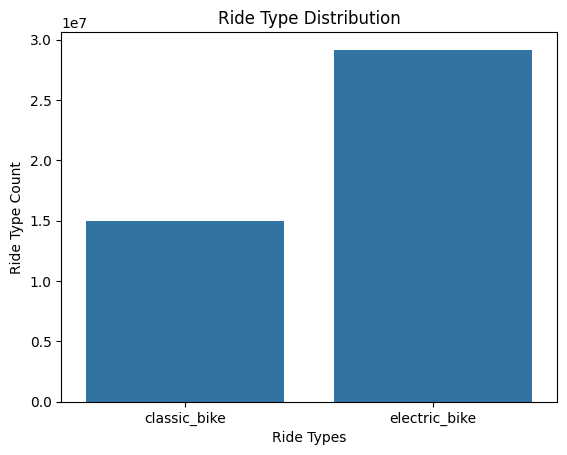

In [30]:
%%time

sns.barplot(x=ride_types.index, y=ride_types)
plt.title("Ride Type Distribution")
plt.xlabel("Ride Types")
plt.ylabel("Ride Type Count");

In [32]:
%%time

member_types = df_cat["member_casual"].value_counts()

CPU times: user 150 ms, sys: 188 ms, total: 339 ms
Wall time: 338 ms


CPU times: user 84.7 ms, sys: 13.8 ms, total: 98.4 ms
Wall time: 75.3 ms


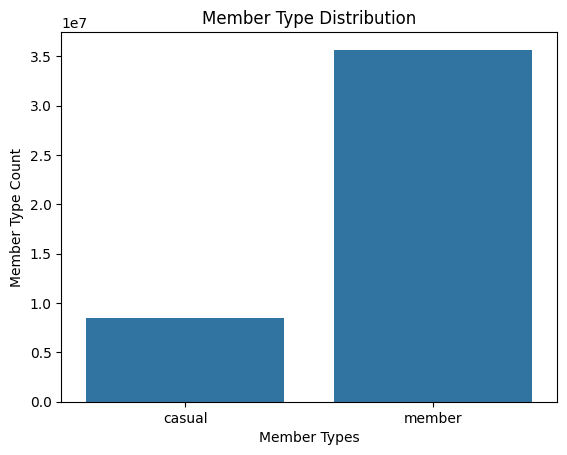

In [33]:
%%time

sns.barplot(x=member_types.index, y=member_types)
plt.title("Member Type Distribution")
plt.xlabel("Member Types")
plt.ylabel("Member Type Count");

In [34]:
del df_cat

In [35]:
del ride_types

In [36]:
del member_types

In [37]:
# Trigger garbage collection manually
gc.collect()

1024

## Trip duration

In [16]:
%%time
# creating copy of dataframe with required features
#df_time = df[['started_at', 'ended_at', 'duration_min']].copy()

clean_data_path = "data/clean/2024"
curr_year = 2024
dates_feats = ['started_at', 'ended_at']
#df_time = read_df_feats(base_path=clean_data_path, year=2024)
df_time = read_df_feats(base_path=clean_data_path, year=curr_year, feats=dates_feats)

Read datetime for 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 1.56 seconds
Read datetime for 202402-citibike-tripdata.parquet
Execution time for 202402-citibike-tripdata.parquet: 1.38 seconds
Read datetime for 202403-citibike-tripdata.parquet
Execution time for 202403-citibike-tripdata.parquet: 1.80 seconds
Read datetime for 202404-citibike-tripdata.parquet
Execution time for 202404-citibike-tripdata.parquet: 2.10 seconds
Read datetime for 202405-citibike-tripdata.parquet
Execution time for 202405-citibike-tripdata.parquet: 2.68 seconds
Read datetime for 202406-citibike-tripdata.parquet
Execution time for 202406-citibike-tripdata.parquet: 4.72 seconds
Read datetime for 202407-citibike-tripdata.parquet
Execution time for 202407-citibike-tripdata.parquet: 4.95 seconds
Read datetime for 202408-citibike-tripdata.parquet
Execution time for 202408-citibike-tripdata.parquet: 4.31 seconds
Read datetime for 202409-citibike-tripdata.parquet
Execution tim

In [19]:
mb_size = df_time.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"The DataFrame occupies approximately {mb_size:.2f} MB")

The DataFrame occupies approximately 673.91 MB


In [5]:
# Duration in minutes
#df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df_time['duration_min'] = (df_time['ended_at'] - df_time['started_at']).dt.total_seconds() / 60

In [6]:
mb_size = df_time.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"El DataFrame ocupa aproximadamente {mb_size:.2f} MB")

El DataFrame ocupa aproximadamente 1010.87 MB


In [7]:
#df['duration_min'].max()
df_time['duration_min'].max()

1537.0006666666666

In [9]:
# creating copy of dataframe with required features
#df_time = df[['started_at', 'ended_at', 'duration_min']].copy()

CPU times: user 2min 24s, sys: 9.3 s, total: 2min 33s
Wall time: 2min 30s


Text(0.5, 1.0, 'Distribution of Trip Duration')

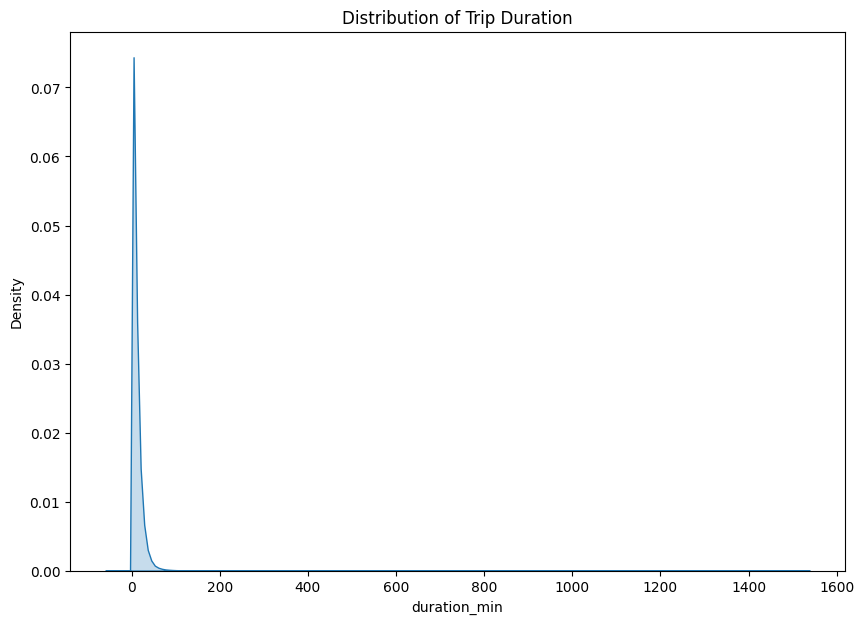

In [10]:
%%time
# kde Plot
plt.figure(figsize=[10,7])
sns.kdeplot(data=df_time, x="duration_min", fill=True);
plt.title('Distribution of Trip Duration')

In [14]:

# Trigger garbage collection manually
gc.collect()

1418

The distribution is heavily skewed to the right. We need to find the upper limit to declare outliers.

**Assumptions**

Looking at the distribution of travel duration data, we can make the following assumptions:

- The maximum travel duration in minutes is 16,000 or more (100 hours), which is clearly incorrect.
- If we think logically, a travel duration greater than 45-60 minutes makes no sense, and this is clearly an outlier due to some problem.

A way to find the upper limit to declare outliers is using IQR.

In [8]:
# find upper bound 
Q3 = np.quantile(df_time['duration_min'],0.75)
Q1 = np.quantile(df_time['duration_min'],0.25)
IQR = Q3-Q1
print(f"25th Percentile: {Q1}")
print(f"75th Percentile: {Q3}")
print(f"Median: {df_time['duration_min'].median()}")
print(f"IQR value is {IQR}")
print(f"Upper Limit is {Q3+1.5*IQR}")
print(f"Lower Limit is {Q1-1.5*IQR}")

25th Percentile: 5.2527833333333325
75th Percentile: 15.742783333333334
Median: 9.068266666666666
IQR value is 10.490000000000002
Upper Limit is 31.477783333333335
Lower Limit is -10.48221666666667


Although the upper limit is **27**, we'll consider **60** as the upper limit. We'll assume that any value above that is an outlier caused by a malfunction.

In [10]:
df_time = df_time[(df_time['duration_min']>0) & (df_time['duration_min']<60)]

In [11]:
mb_size = df_time.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"The DataFrame occupies approximately {mb_size:.2f} MB")

The DataFrame occupies approximately 1334.37 MB


CPU times: user 2min 29s, sys: 11 s, total: 2min 40s
Wall time: 2min 37s


Text(0.5, 1.0, 'Distribution of Trip Duration')

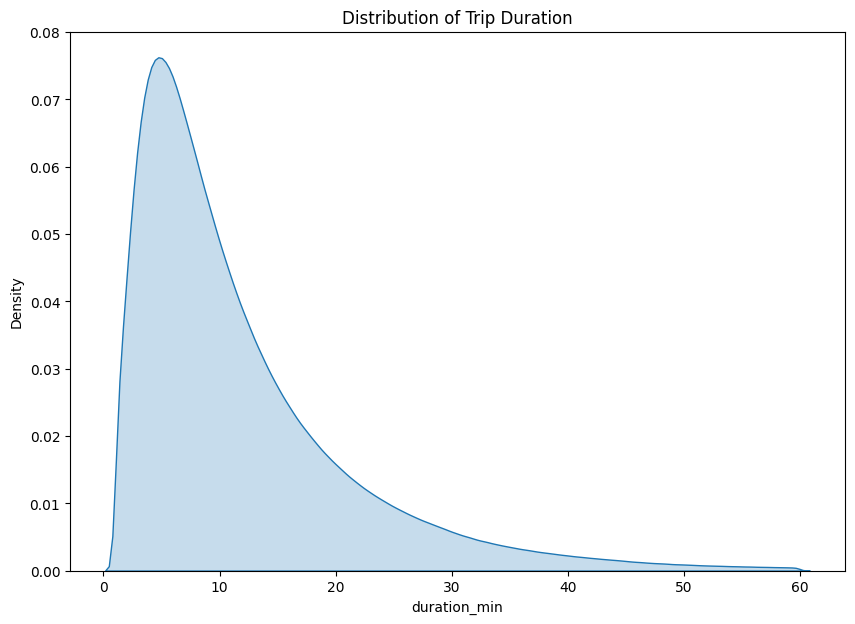

In [12]:
%%time
plt.figure(figsize=[10,7])
#sns.kdeplot(temp, fill=True)
sns.kdeplot(data=df_time, x="duration_min", fill=True)
plt.title('Distribution of Trip Duration')

In [23]:
df_time[(df_time['duration_min']>0) & (df_time['duration_min']<1)]

,started_at,ended_at,duration_min


In [13]:
df_time[(df_time['duration_min']<0)]

,started_at,ended_at,duration_min


In [20]:
del df_time

In [21]:
# Trigger garbage collection manually
gc.collect()

0

## Temporal Analysis 

In [4]:
%%time 
#dt_df =  df[['started_at', 'ended_at']].copy()

clean_data_path = "data/clean/2024"
curr_year = 2024
dates_feats = ['started_at']
dt_df = read_df_feats(base_path=clean_data_path, year=curr_year, from_month=1, to_month=12, feats=dates_feats)

Read datetime for 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 1.80 seconds
Read datetime for 202402-citibike-tripdata.parquet
Execution time for 202402-citibike-tripdata.parquet: 1.94 seconds
Read datetime for 202403-citibike-tripdata.parquet
Execution time for 202403-citibike-tripdata.parquet: 2.18 seconds
Read datetime for 202404-citibike-tripdata.parquet
Execution time for 202404-citibike-tripdata.parquet: 2.90 seconds
Read datetime for 202405-citibike-tripdata.parquet
Execution time for 202405-citibike-tripdata.parquet: 3.47 seconds
Read datetime for 202406-citibike-tripdata.parquet
Execution time for 202406-citibike-tripdata.parquet: 6.68 seconds
Read datetime for 202407-citibike-tripdata.parquet
Execution time for 202407-citibike-tripdata.parquet: 4.97 seconds
Read datetime for 202408-citibike-tripdata.parquet
Execution time for 202408-citibike-tripdata.parquet: 5.92 seconds
Read datetime for 202409-citibike-tripdata.parquet
Execution tim

In [5]:
mb_size = dt_df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"The DataFrame occupies approximately {mb_size:.2f} MB")

The DataFrame occupies approximately 673.91 MB


In [68]:
# Trigger garbage collection manually
gc.collect()

0

In [ ]:
%%time
# creating hour of day
dt_df['HOD'] =  dt_df['started_at'].dt.hour

# creating day of the year feature
dt_df['DOY'] = dt_df['started_at'].dt.dayofyear

# creating day of the week feature
dt_df['DOW'] = dt_df['started_at'].dt.dayofweek
dt_df['weekday'] = dt_df["started_at"].dt.day_name()

# creating day of the month feature
dt_df['DOM'] = dt_df['started_at'].dt.day

# creating day of the month feature
dt_df['DOY'] = dt_df['started_at'].dt.dayofyear

# creating year column
dt_df['year'] = dt_df['started_at'].dt.year

# creating month number column
dt_df['month_num'] = dt_df['started_at'].dt.month
dt_df['month'] = dt_df['started_at'].dt.month_name()

# convert datetime column to just date
dt_df['date'] = pd.to_datetime(dt_df['started_at']).dt.date

### Month of year

In [8]:
%%time
# creating month number column
dt_df['month_num'] = dt_df['started_at'].dt.month
#dt_df['month'] = dt_df['started_at'].dt.month_name()

CPU times: user 990 ms, sys: 265 ms, total: 1.25 s
Wall time: 1.24 s


In [9]:
dt_df.head(5)

,started_at,ended_at,month_num
0,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,1
1,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,1
2,2024-01-22 21:18:25.199,2024-01-22 21:26:24.647,1
3,2024-01-31 22:15:49.861,2024-01-31 22:22:45.520,1
4,2024-01-29 22:52:28.276,2024-01-29 22:57:05.099,1


In [16]:
%%time
#df_weekdata = df['DOW'].value_counts().reset_index()
#df_monthdata = dt_df[['date', 'month', 'month_num']].value_counts().reset_index()
#df_monthdata.columns = ['date', 'month', 'month_num', 'trips']

#df_monthdata = dt_df[['month', 'month_num']].value_counts().reset_index()
#df_monthdata.columns = ['month', 'month_num', 'trips']
#df_monthdata = df_monthdata.sort_values(by='month_num', ascending=True).reset_index(drop=True)

df_monthdata = dt_df[['month_num']].value_counts().reset_index()
df_monthdata.columns = ['month_num', 'trips']
df_monthdata['month'] = df_monthdata['month_num'].apply(lambda x: calendar.month_name[x])
df_monthdata = df_monthdata.sort_values(by='month_num', ascending=True).reset_index(drop=True)

CPU times: user 677 ms, sys: 648 ms, total: 1.32 s
Wall time: 1.33 s


In [17]:
df_monthdata.head(5)

,month_num,trips,month
0,1,1881808,January
1,2,2116002,February
2,3,2656178,March
3,4,3208973,April
4,5,4124878,May


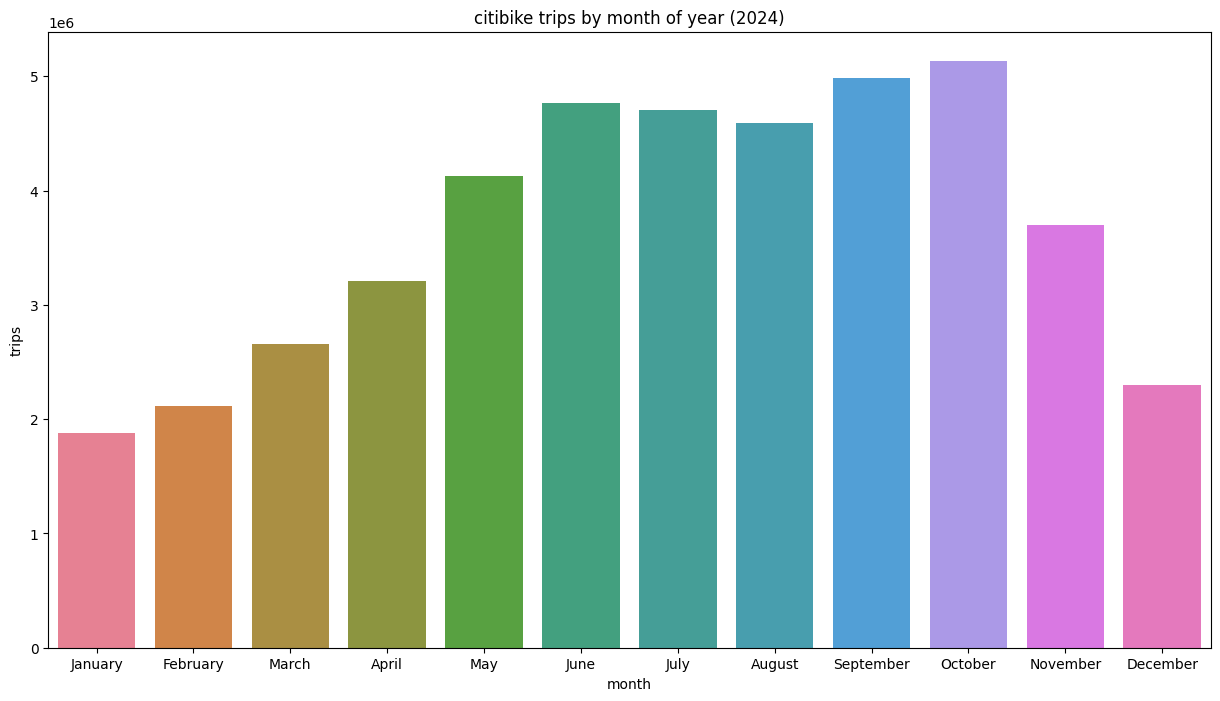

CPU times: user 364 ms, sys: 148 ms, total: 512 ms
Wall time: 317 ms


In [52]:
%%time
plt.figure(figsize=[15,8])
#plot=sns.boxplot(data=df_weekdata, x=df_weekdata['weekday'], y=df_weekdata['trips'], hue='')
#plot=sns.boxplot(data=df_weekdata, x='weekday', y='trips', hue='weekday')
plot=sns.barplot(df_monthdata, x="month", y="trips", hue="month", legend=False)
plt.title('citibike trips by month of year (2024)')
plt.show();

In [53]:
del df_monthdata

In [54]:
month_feat = 'month_num'
if month_feat in dt_df.columns:
    print(f'Droping colums {month_feat}')
    # Drop column 'B' inplace
    dt_df.drop(month_feat, axis=1, inplace=True)

NameError: name 'dt_df' is not defined

In [56]:
# Trigger garbage collection manually
gc.collect()

0

### Day of week

In [24]:
# creating day of the week feature
dt_df['DOW'] = dt_df['started_at'].dt.dayofweek
#dt_df['weekday'] = dt_df["started_at"].dt.day_name()

In [26]:
%%time
#df_weekdata = df['DOW'].value_counts().reset_index()
#df_weekdata = dt_df[['date', 'weekday', 'DOW']].value_counts().reset_index()
#df_weekdata.columns = ['date', 'weekday', 'DOW', 'trips']
#df_weekdata = df_weekdata.sort_values(by='DOW', ascending=True)

#df_weekdata = dt_df[['weekday', 'DOW']].value_counts().reset_index()
#df_weekdata.columns = ['weekday', 'DOW', 'trips']
#df_weekdata = df_weekdata.sort_values(by='DOW', ascending=True).reset_index(drop=True)

df_weekdata = dt_df[['DOW']].value_counts().reset_index()
df_weekdata.columns = ['DOW', 'trips']
df_weekdata['weekday'] = df_weekdata['DOW'].apply(lambda x: calendar.day_name[x])
df_weekdata = df_weekdata.sort_values(by='DOW', ascending=True).reset_index(drop=True)

CPU times: user 583 ms, sys: 689 ms, total: 1.27 s
Wall time: 1.28 s


In [27]:
df_weekdata.head(7)

,DOW,trips,weekday
0,0,6254509,Monday
1,1,6686758,Tuesday
2,2,6642703,Wednesday
3,3,6497142,Thursday
4,4,6560312,Friday
5,5,6020598,Saturday
6,6,5503557,Sunday


In [102]:
#plt.figure(figsize=[15,8])
#plot=sns.boxplot(data=df_weekdata, x=df_weekdata['weekday'], y=df_weekdata['trips'], hue='')
#plot=sns.boxplot(data=dt_df, x='weekday',  hue='weekday')
#plt.title('Distribution of Number of trips by Day of week for year 20XX')
#plt.show();

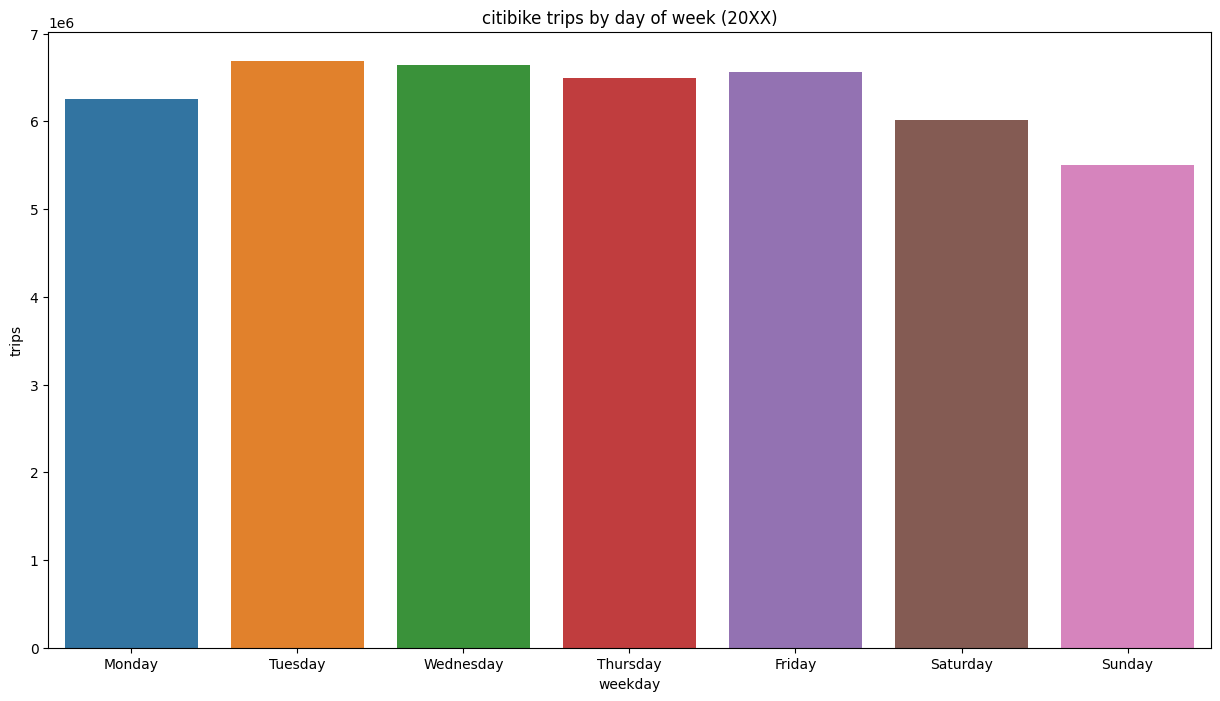

CPU times: user 314 ms, sys: 119 ms, total: 433 ms
Wall time: 242 ms


In [57]:
%%time
plt.figure(figsize=[15,8])
#plot=sns.boxplot(data=df_weekdata, x=df_weekdata['weekday'], y=df_weekdata['trips'], hue='')
#plot=sns.boxplot(data=df_weekdata, x='weekday', y='trips', hue='weekday')
plot=sns.barplot(df_weekdata, x="weekday", y="trips", hue="weekday", legend=False)
plt.title('citibike trips by day of week (20XX)')
plt.show();

In [58]:
del df_weekdata

In [29]:
dow_feat = 'DOW'
if dow_feat in dt_df.columns:
    print(f'Droping colums {dow_feat}')
    # Drop column 'B' inplace
    dt_df.drop(dow_feat, axis=1, inplace=True)

Droping colums DOW


In [60]:
# Trigger garbage collection manually
gc.collect()

0

### Day of year

In [30]:
# creating day of the year feature
dt_df['DOY'] = dt_df['started_at'].dt.dayofyear

In [31]:
dt_df.head(5)

,started_at,ended_at,DOY
0,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,24
1,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,30
2,2024-01-22 21:18:25.199,2024-01-22 21:26:24.647,22
3,2024-01-31 22:15:49.861,2024-01-31 22:22:45.520,31
4,2024-01-29 22:52:28.276,2024-01-29 22:57:05.099,29


In [32]:
%%time
#df_weekdata = df['DOW'].value_counts().reset_index()
df_doydata = dt_df[['DOY']].value_counts().reset_index()
df_doydata.columns = ['day', 'trips']
df_doydata = df_doydata.sort_values(by='day', ascending=True).reset_index(drop=True)

CPU times: user 676 ms, sys: 640 ms, total: 1.32 s
Wall time: 1.31 s


In [33]:
df_doydata.head(5)

,day,trips
0,1,47031
1,2,67838
2,3,76213
3,4,77273
4,5,72233


CPU times: user 2 μs, sys: 2 μs, total: 4 μs
Wall time: 6.44 μs


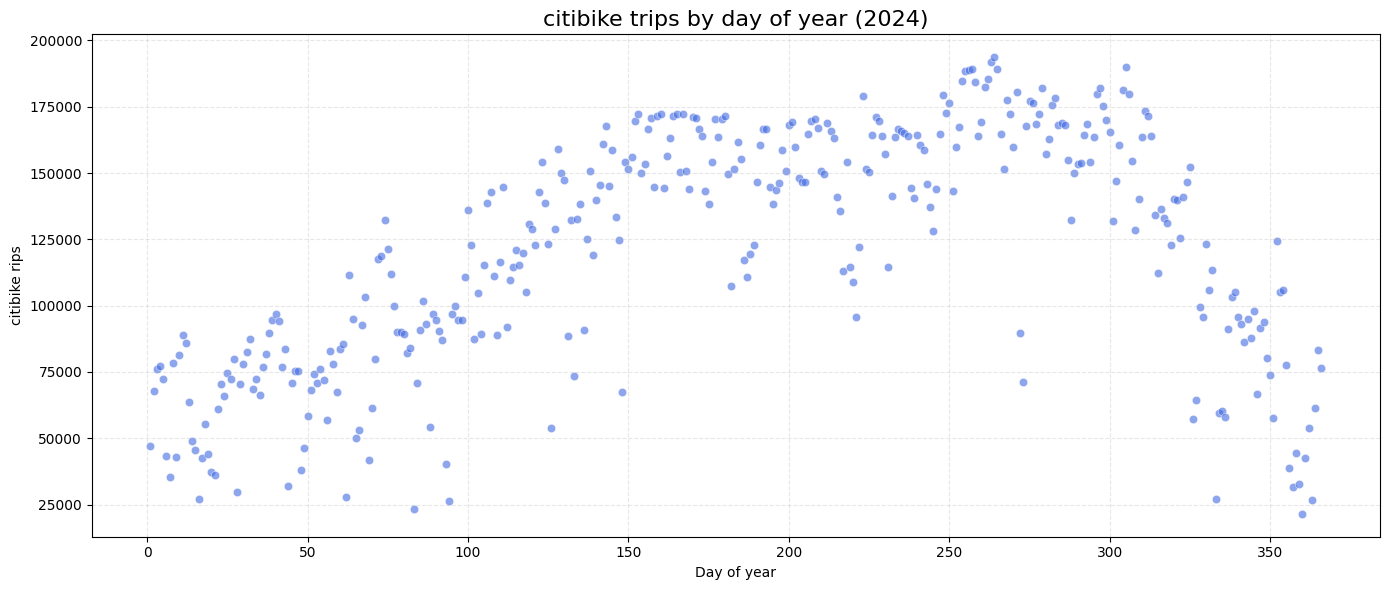

In [36]:
%time
# Graficar
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df_doydata, x='day', y='trips', alpha=0.6, color='royalblue')
plt.title("citibike trips by day of year (2024)", fontsize=16)
plt.xlabel("Day of year")
plt.ylabel("citibike rips")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [50]:
del df_doydata

In [37]:
doy_feat = 'DOY'
if doy_feat in dt_df.columns:
    print(f'Droping colums {doy_feat}')
    # Drop column 'B' inplace
    dt_df.drop(doy_feat, axis=1, inplace=True)

Droping colums DOY


In [51]:
# Trigger garbage collection manually
gc.collect()

0

### Hour of day

In [38]:
%%time
# creating hour of day
dt_df['HOD'] =  dt_df['started_at'].dt.hour

CPU times: user 833 ms, sys: 243 ms, total: 1.08 s
Wall time: 1.08 s


In [40]:
dt_df.head(5)

,started_at,ended_at,HOD
0,2024-01-24 09:03:33.533,2024-01-24 09:06:53.535,9
1,2024-01-30 08:21:29.510,2024-01-30 08:29:03.304,8
2,2024-01-22 21:18:25.199,2024-01-22 21:26:24.647,21
3,2024-01-31 22:15:49.861,2024-01-31 22:22:45.520,22
4,2024-01-29 22:52:28.276,2024-01-29 22:57:05.099,22


In [41]:
%%time
#df_weekdata = df['DOW'].value_counts().reset_index()
df_hourdata = dt_df[['HOD']].value_counts().reset_index()
df_hourdata.columns = ['hour', 'trips']
df_hourdata = df_hourdata.sort_values(by='hour', ascending=True).reset_index(drop=True)

CPU times: user 624 ms, sys: 635 ms, total: 1.26 s
Wall time: 1.27 s


In [42]:
df_hourdata.head(5)

,hour,trips
0,0,620604
1,1,373159
2,2,238739
3,3,159232
4,4,143742


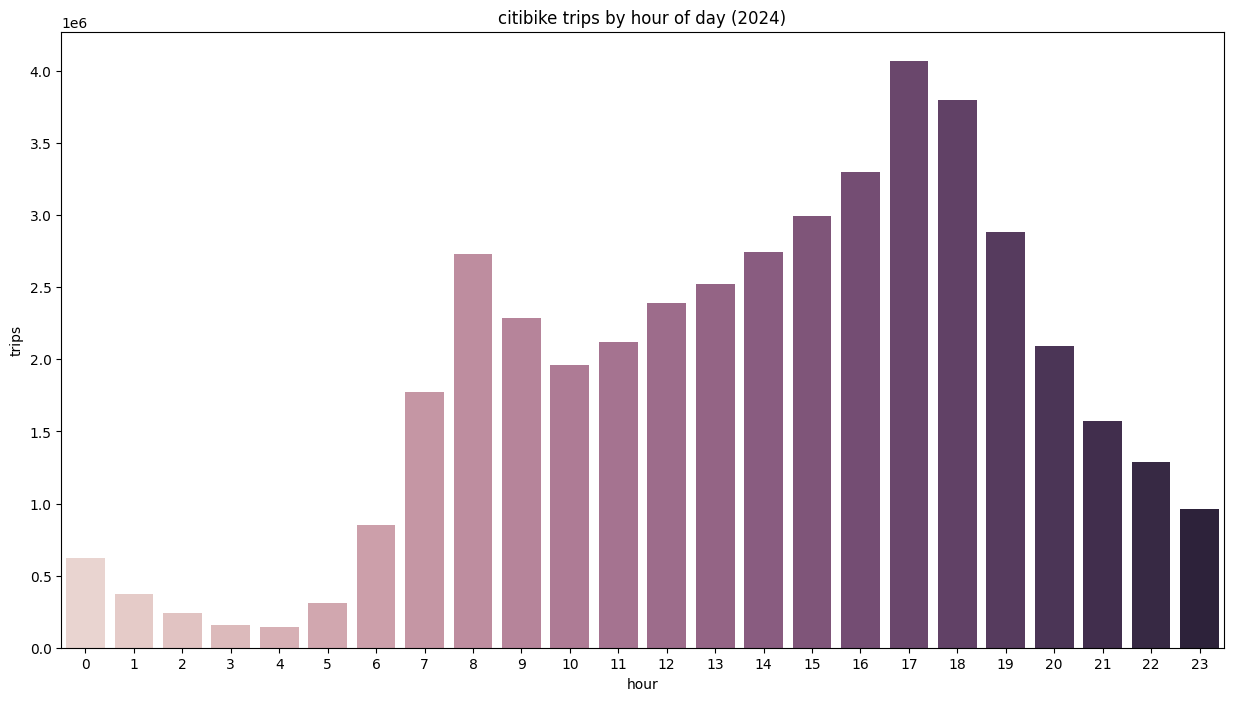

CPU times: user 514 ms, sys: 127 ms, total: 641 ms
Wall time: 459 ms


In [44]:
%%time
plt.figure(figsize=[15,8])
#plot=sns.boxplot(data=df_weekdata, x=df_weekdata['weekday'], y=df_weekdata['trips'], hue='')
#plot=sns.boxplot(data=df_weekdata, x='weekday', y='trips', hue='weekday')
plot=sns.barplot(df_hourdata, x="hour", y="trips", hue="hour", legend=False)
plt.title('citibike trips by hour of day (2024)')
plt.show();

In [48]:
del df_hourdata

In [45]:
# Remove datatime dataframe
del dt_df

In [82]:
# Trigger garbage collection manually
gc.collect()

0

### Holidays

## Station Analysis

### Busy Station

In [33]:
%%time

clean_data_path = "data/clean/2024"
curr_year = 2024
station_feats = ['start_station_name']
start_stationroutes_df = read_df_feats(base_path=clean_data_path, year=curr_year, feats=station_feats)

year: 2024, months: 1 to  1
Read datetime for 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 3.29 seconds
CPU times: user 1.56 s, sys: 1.81 s, total: 3.37 s
Wall time: 3.29 s


In [8]:
%%time
# Count most common routes
#top_start_station = df['start_station_name'].value_counts().head(20).reset_index()
top_start_station = start_stationroutes_df['start_station_name'].value_counts().reset_index()
top_start_station.columns = ['start_station_name', 'trips']

# Reverse order for nicer plotting
top_start_station = top_start_station.sort_values(by='trips', ascending=False)

CPU times: user 3.4 s, sys: 33.2 ms, total: 3.43 s
Wall time: 3.37 s


In [34]:
# Trigger garbage collection manually
gc.collect()

0

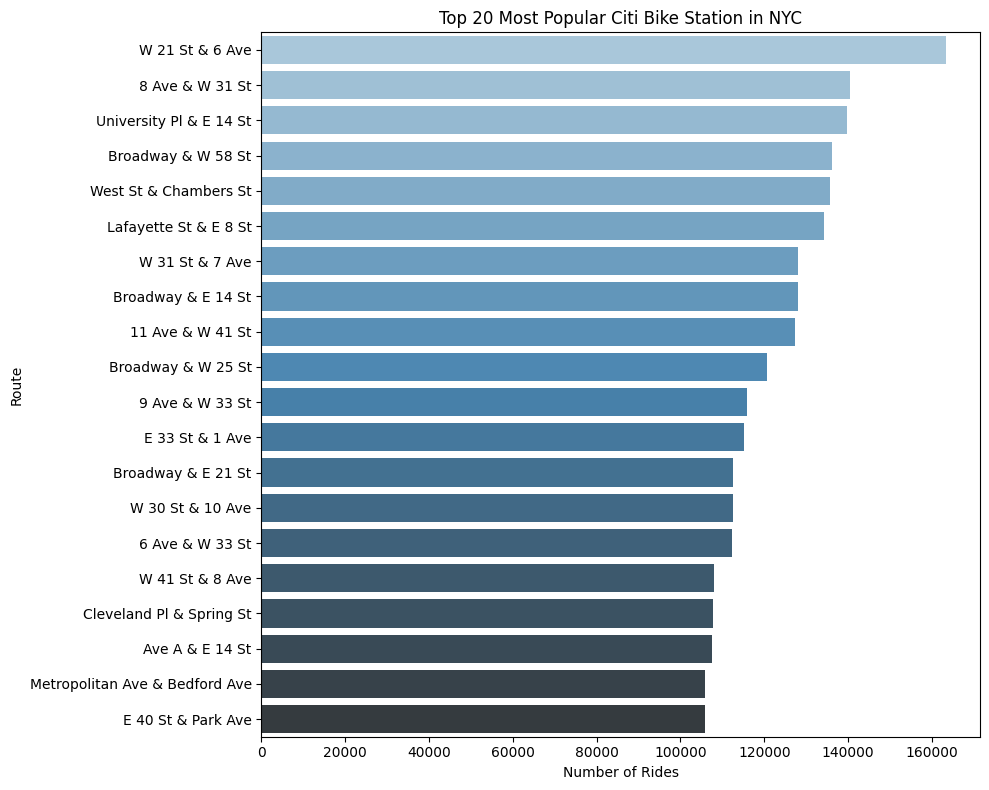

CPU times: user 554 ms, sys: 255 ms, total: 809 ms
Wall time: 470 ms


In [10]:
%%time
# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_start_station.head(20), x='trips', y='start_station_name', palette='Blues_d', hue='start_station_name')
plt.title('Top 20 Most Popular Citi Bike Station in NYC')
plt.xlabel('Number of Rides')
plt.ylabel('Route')
plt.tight_layout()
plt.show()

In [11]:
del start_stationroutes_df

In [12]:
del top_start_station

In [3]:
# Trigger garbage collection manually
gc.collect()

0

In [4]:
dir()

['Annotated',
 'Dict',
 'In',
 'Out',
 'Tuple',
 'Unit',
 '_',
 '_3',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__session__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_i3',
 '_i4',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'calendar',
 'ds',
 'duckdb',
 'exit',
 'gc',
 'get_ipython',
 'glob',
 'haversine',
 'holidays',
 'logging',
 'np',
 'open',
 'os',
 'pa',
 'pd',
 'plt',
 'pq',
 'quit',
 'read_df_feats',
 'requests',
 'sns',
 'time',
 'zipfile']

### Route

In [10]:
# Route from start station to end station
#routes_df['route'] = stations_df['start_station_name'] + ' to ' + stations_df['end_station_name']

In [3]:
%%time

clean_data_path = "data/clean/2024"
curr_year = 2024
station_feats = ['start_station_name', 'end_station_name']

df_list = []
page_size = 3
for page_num in range(1, 5):
    from_month = (page_num - 1) * page_size
    to_month = from_month + page_size
    stations_df = read_df_feats(base_path=clean_data_path, year=curr_year, from_month=from_month + 1, to_month=to_month, feats=station_feats)

    routes = stations_df['start_station_name'] + ' to ' + stations_df['end_station_name']
    df_list.append(routes)
    
    del stations_df
    #del routes
    # Trigger garbage collection manually
    gc.collect()

# Trigger garbage collection manually
gc.collect()

routes_df = pd.concat(df_list, axis=0, ignore_index=True).to_frame()
routes_df.columns = ['route']
del df_list

# Trigger garbage collection manually
gc.collect()

year: 2024, months: 1 to  3
Read datetime for 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 1.79 seconds
Read datetime for 202402-citibike-tripdata.parquet
Execution time for 202402-citibike-tripdata.parquet: 1.71 seconds
Read datetime for 202403-citibike-tripdata.parquet
Execution time for 202403-citibike-tripdata.parquet: 1.99 seconds
year: 2024, months: 4 to  6
Read datetime for 202404-citibike-tripdata.parquet
Execution time for 202404-citibike-tripdata.parquet: 2.33 seconds
Read datetime for 202405-citibike-tripdata.parquet
Execution time for 202405-citibike-tripdata.parquet: 2.97 seconds
Read datetime for 202406-citibike-tripdata.parquet
Execution time for 202406-citibike-tripdata.parquet: 4.78 seconds
year: 2024, months: 7 to  9
Read datetime for 202407-citibike-tripdata.parquet
Execution time for 202407-citibike-tripdata.parquet: 4.74 seconds
Read datetime for 202408-citibike-tripdata.parquet
Execution time for 202408-citibike-tripdata.pa

0

In [4]:
# Trigger garbage collection manually
gc.collect()

0

In [5]:
routes_df.head(5)

,route
0,E 102 St & 1 Ave to E 103 St & Lexington Ave
1,E 102 St & 1 Ave to E 91 St & 2 Ave
2,W 35 St & 8 Ave to 1 Ave & E 39 St
3,Warren St & Roosevelt Ave to 112 St & Northern...
4,6 Ave & W 33 St to W 29 St & 9 Ave


In [6]:
clean_data_path = "data/clean/2024"
routes_file = "routes.parquet"
routes_path = os.path.join(clean_data_path, routes_file)
routes_df.to_parquet(routes_path, engine='pyarrow')

In [7]:
#del stations_df
# Trigger garbage collection manually
gc.collect()

0

In [9]:
mb_size = routes_df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"The DataFrame occupies approximately {mb_size:.2f} MB")

The DataFrame occupies approximately 3926.21 MB


In [10]:
# Trigger garbage collection manually
gc.collect()

0

In [11]:
!ls -lh "{clean_data_path}"

total 2.5G
-rw-r--r-- 1 emmuzoo emmuzoo  82M Jul 22 20:55 202401-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo  92M Jul 22 20:55 202402-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 116M Jul 22 20:55 202403-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 139M Jul 22 20:55 202404-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 179M Jul 22 20:55 202405-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 206M Jul 22 20:56 202406-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 203M Jul 22 20:56 202407-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 197M Jul 22 20:56 202408-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 216M Jul 22 20:56 202409-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 222M Jul 22 20:56 202410-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 161M Jul 22 20:57 202411-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 100M Jul 22 20:57 202412-citibike-tripdata.parquet
-rw-r--r-- 1 emmuzoo emmuzoo 

In [12]:
# Trigger garbage collection manually
gc.collect()

0

In [14]:
# Count most common routes
top_routes = routes_df['route'].value_counts().reset_index()
top_routes.columns = ['route', 'trips']

# Reverse order for nicer plotting
top_routes = top_routes.sort_values(by='trips', ascending=False)

In [15]:
top_routes.head(5)

,route,trips
0,Central Park S & 6 Ave to Central Park S & 6 Ave,15571
1,7 Ave & Central Park South to 7 Ave & Central ...,12616
2,Roosevelt Island Tramway to Roosevelt Island T...,8827
3,River Ter & Warren St to Vesey Pl & River Terrace,7367
4,Soissons Landing to Soissons Landing,6232


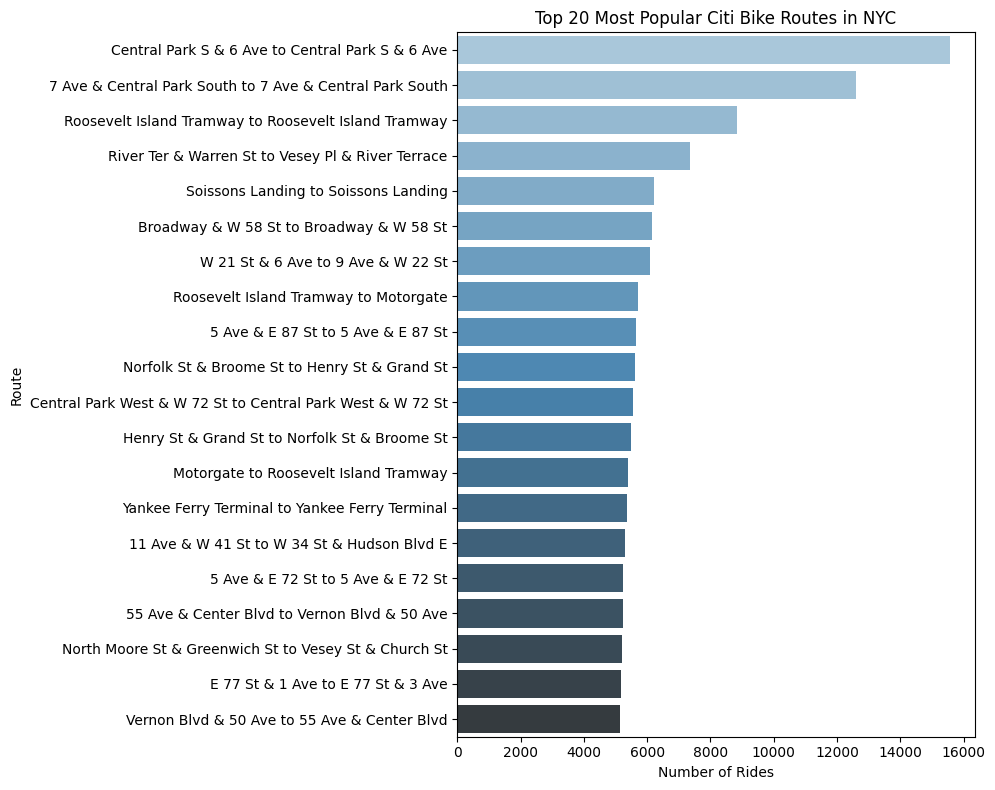

CPU times: user 909 ms, sys: 563 ms, total: 1.47 s
Wall time: 649 ms


In [17]:
%%time
# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_routes.head(20), x='trips', y='route', palette='Blues_d', hue='route')
plt.title('Top 20 Most Popular Citi Bike Routes in NYC')
plt.xlabel('Number of Rides')
plt.ylabel('Route')
plt.tight_layout()
plt.show()

In [18]:
#df[ df['route'].str.startswith("Central") ][["route", "start_station_name", "end_station_name"]]

In [19]:
#df[ df['start_station_name'] == df['end_station_name'] ][["route", "start_station_name", "end_station_name", "duration_min"]].shape

In [20]:
#df[ df['start_station_name'] != df['end_station_name'] ][["route", "start_station_name", "end_station_name", "duration_min"]]

In [21]:
#top_start_station.head(5)

In [22]:
#top_routes[top_routes['route'].str.startswith("W 21")]

In [23]:
#top_routes[top_routes['route'].str.startswith("1 Ave & E 68 St")]

In [25]:
del routes_df

In [28]:
del top_routes

In [30]:
# Trigger garbage collection manually
gc.collect()

0

In [27]:
dir()

['Annotated',
 'Dict',
 'In',
 'Out',
 'Tuple',
 'Unit',
 '_',
 '_10',
 '_12',
 '_15',
 '_24',
 '_26',
 '_3',
 '_4',
 '_5',
 '_7',
 '_8',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__session__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'calendar',
 'clean_data_path',
 'curr_year',
 'ds',
 'duckdb',
 'exit',
 'from_month',
 'gc',
 'get_ipython',
 'glob',
 'haversine',
 'holidays',
 'logging',
 'mb_size',
 'np',
 'open',
 'os',
 'pa',
 'page_num',
 'page_size',
 'pd',
 'plt',
 'pq',
 'quit',
 'read_df_feats',
 'requests',
 'routes',
 'routes_file',
 'routes_path',
 'sns',
 'station_feats',
 'time',
 'to_month',
 'top_routes',
 'zipfile']

# Final

## Citibike trips

In [63]:
def create_final_ds(
    base_path: str,
    year: int = 2024,
    from_month: int = 1,
    to_month: int = None,
    output_path: str = None
) -> pd.DataFrame:
    # List to store individual DataFrames
    #if not feats:
    #    print(f"Features is empty")
    #    return None
    
    assert from_month >= 1 & from_month <= 12, "from_month must be between 1 and 12" 
    if not to_month:
        to_month = from_month
    assert to_month >= 1 & to_month <= 12, "to_month must be between 1 and 12" 
    assert from_month <= to_month, "from_month must be less than or equal to to_month" 
        
    df_list = []

    # Obtener los días festivos de EE.UU. para 2023
    us_holidays = holidays.US(years=year)

    #src_data_dir = os.path.join(base_path, str(year))
    #dest_data_dir = os.path.join(output_path, str(year))
    #os.makedirs(src_data_dir, exist_ok=True)
    #os.makedirs(dest_data_dir, exist_ok=True)

    print(f"year: {year}, months: {from_month} to  {to_month}")
    for month in range(from_month, to_month + 1):
        start_time = time.time()
        file_name = f"{year}{month:02d}-citibike-tripdata.parquet"
        #file_path = os.path.join(src_data_dir, file_name)
        file_path = os.path.join(base_path, file_name)

        print(f"Read datetime for {file_name}")
        # Read file parquet
        df = pd.read_parquet(file_path, engine='pyarrow')

        # Remove duration trip less than 0 and grester than 60
        df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
        df = df[(df['duration_min']>0) & (df['duration_min']<60)]
        
        # Create 'date' column
        df['date'] = df['started_at'].dt.date
        df['hour'] = df['started_at'].dt.hour
        
        # Group trips 
        bike_trips_df = df.groupby(['date', 'hour']).size().reset_index(name='trips')
        
        # Create  holiday' column
        bike_trips_df['holiday'] = bike_trips_df['date'].apply(lambda x: 1 if x in us_holidays else 0)

        # Create 'date' y 'hour' columnas  para formar una fecha completa
        #bike_trips_df['date'] = pd.to_datetime(bike_trips_df['date'].astype(str) + ' ' + bike_trips_df['hour'].astype(str) + ':00')
        bike_trips_df['date'] = pd.to_datetime(bike_trips_df['date'])

        # Drop columns
        #bike_trips_df.drop(columns=["hour"], inplace=True)
        
        # creating copy of dataframe with required features
        df_list.append(bike_trips_df)

        # Remove dataframe
        del df
        #del bike_trips_df

        # Trigger garbage collection manually
        gc.collect()
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Execution time for {file_name}: {elapsed_time:.2f} seconds")

    # Trigger garbage collection manually
    gc.collect()

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    del df_list
    
    parquet_file = f"{year}-citibike-tripdata.parquet"
    #parquet_path = os.path.join(dest_data_dir, parquet_file)
    parquet_path = os.path.join(output_path, parquet_file)
    combined_df.to_parquet(parquet_path, engine="pyarrow", index=False)

    del combined_df
        
    # Trigger garbage collection manually
    gc.collect()
    
    #return combined_df
    

In [64]:
# Trigger garbage collection manually
gc.collect()

3041

In [65]:
%%time

curr_year=2024
from_month=1
to_month=12
src_train_data_path = f"data/parquet/{curr_year}"
final_train_data_path = f"data/final/{curr_year}"

create_final_ds(
    base_path=src_train_data_path,
    year=curr_year,
    from_month=from_month,
    to_month=to_month,
    output_path=final_train_data_path
)

year: 2024, months: 1 to  12
Read datetime for 202401-citibike-tripdata.parquet
Execution time for 202401-citibike-tripdata.parquet: 2.57 seconds
Read datetime for 202402-citibike-tripdata.parquet
Execution time for 202402-citibike-tripdata.parquet: 2.86 seconds
Read datetime for 202403-citibike-tripdata.parquet
Execution time for 202403-citibike-tripdata.parquet: 3.49 seconds
Read datetime for 202404-citibike-tripdata.parquet
Execution time for 202404-citibike-tripdata.parquet: 4.21 seconds
Read datetime for 202405-citibike-tripdata.parquet
Execution time for 202405-citibike-tripdata.parquet: 4.71 seconds
Read datetime for 202406-citibike-tripdata.parquet
Execution time for 202406-citibike-tripdata.parquet: 8.76 seconds
Read datetime for 202407-citibike-tripdata.parquet
Execution time for 202407-citibike-tripdata.parquet: 8.85 seconds
Read datetime for 202408-citibike-tripdata.parquet
Execution time for 202408-citibike-tripdata.parquet: 8.37 seconds
Read datetime for 202409-citibike-t

In [69]:
# Show sample
curr_year = 2024
final_train_data_path = f"data/final/{curr_year}"
parquet_file = f"{curr_year}-citibike-tripdata.parquet"
parquet_path = os.path.join(final_train_data_path, parquet_file)
final_train_ds_df = pd.read_parquet(parquet_path)

In [67]:
final_train_ds_df.shape

(8795, 4)

In [70]:
final_train_ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     8795 non-null   datetime64[ns]
 1   hour     8795 non-null   int32         
 2   trips    8795 non-null   int64         
 3   holiday  8795 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 240.6 KB


In [68]:
final_train_ds_df.head()

,date,hour,trips,holiday
0,2023-12-31,23,278,0
1,2024-01-01,0,1863,1
2,2024-01-01,1,2291,1
3,2024-01-01,2,1903,1
4,2024-01-01,3,1081,1


In [71]:
%%time

# Generate test data
curr_year = 2025
from_month=1
to_month=3
test_data_path = f"data/parquet/{curr_year}"
final_test_data_path = f"data/final/{curr_year}"

create_final_ds(
    base_path=test_data_path,
    year=curr_year,
    from_month=from_month,
    to_month=to_month,
    output_path=final_test_data_path
)

year: 2025, months: 1 to  3
Read datetime for 202501-citibike-tripdata.parquet
Execution time for 202501-citibike-tripdata.parquet: 2.81 seconds
Read datetime for 202502-citibike-tripdata.parquet
Execution time for 202502-citibike-tripdata.parquet: 2.69 seconds
Read datetime for 202503-citibike-tripdata.parquet
Execution time for 202503-citibike-tripdata.parquet: 4.28 seconds
CPU times: user 9.47 s, sys: 3.17 s, total: 12.6 s
Wall time: 10 s


In [73]:
curr_year = 2025
final_test_data_path = f"data/final/{curr_year}"
parquet_file = f"{curr_year}-citibike-tripdata.parquet"
parquet_path = os.path.join(final_test_data_path, parquet_file)
final_test_ds_df = pd.read_parquet(parquet_path)

In [74]:
final_test_ds_df.shape

(2162, 4)

In [76]:
final_test_ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162 entries, 0 to 2161
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2162 non-null   datetime64[ns]
 1   hour     2162 non-null   int32         
 2   trips    2162 non-null   int64         
 3   holiday  2162 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 59.2 KB


In [77]:
final_test_ds_df.head()

,date,hour,trips,holiday
0,2024-12-31,23,162,0
1,2025-01-01,0,1585,1
2,2025-01-01,1,2682,1
3,2025-01-01,2,2263,1
4,2025-01-01,3,1326,1


## Weather data

In [93]:
# Read train weather data
curr_year = 2024
train_data_dir = f"data/parquet/{curr_year}"
weather_data_file = f"{curr_year}-weather.parquet"
weather_data_path = os.path.join(train_data_dir, weather_data_file)
train_weather_data = pd.read_parquet(weather_data_path)

In [107]:
train_weather_data.shape

(366, 8)

In [108]:
train_weather_data.head(5)

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0
1,2024-01-02,9.4,0.00,0.0,0.0,37.0,43.0,30.0
2,2024-01-03,9.2,0.00,0.0,0.0,39.0,43.0,35.0
3,2024-01-04,15.0,0.00,0.0,0.0,41.0,45.0,29.0
4,2024-01-05,11.9,0.00,0.0,0.0,32.0,38.0,27.0


In [122]:
train_climate = train_weather_data[['DATE','TMAX','TMIN','SNOW']]
train_climate.head()

,DATE,TMAX,TMIN,SNOW
0,2024-01-01,47.0,36.0,0.0
1,2024-01-02,43.0,30.0,0.0
2,2024-01-03,43.0,35.0,0.0
3,2024-01-04,45.0,29.0,0.0
4,2024-01-05,38.0,27.0,0.0


In [124]:
# File
curr_year = 2024
train_weather_data_file = f"{curr_year}-weather.parquet"
# Source
src_train_data_dir = f"data/parquet/{curr_year}"
src_train_weather_data_path = os.path.join(src_train_data_dir, train_weather_data_file)
# Target
dest_train_data_dir = f"data/final/{curr_year}"
dest_train_weather_data_path = os.path.join(dest_train_data_dir, train_weather_data_file)
# Copy
shutil.copyfile(src_train_weather_data_path, dest_train_weather_data_path)

'data/final/2024/2024-weather.parquet'

In [114]:
curr_year = 2025
test_data_dir = f"data/parquet/{curr_year}"
weather_data_file = f"{curr_year}-weather.parquet"
weather_data_path = os.path.join(test_data_dir, weather_data_file)
test_weather_data = pd.read_parquet(weather_data_path)

In [115]:
test_weather_data.shape

(88, 8)

In [116]:
test_weather_data.head(5)

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0
1,2025-01-02,20.4,0.0,0.0,0.0,41.0,44.0,35.0
2,2025-01-03,14.3,0.0,0.0,0.0,36.0,40.0,32.0
3,2025-01-04,22.1,0.0,0.0,0.0,33.0,34.0,29.0
4,2025-01-05,16.6,0.0,0.0,0.0,30.0,34.0,28.0


In [125]:
test_climate = test_weather_data[['DATE','TMAX','TMIN','SNOW']]
test_climate.head()

,DATE,TMAX,TMIN,SNOW
0,2025-01-01,52.0,40.0,0.0
1,2025-01-02,44.0,35.0,0.0
2,2025-01-03,40.0,32.0,0.0
3,2025-01-04,34.0,29.0,0.0
4,2025-01-05,34.0,28.0,0.0


In [126]:
# File
curr_year = 2025
test_weather_data_file = f"{curr_year}-weather.parquet"
# Source
src_test_data_dir = f"data/parquet/{curr_year}"
src_test_weather_data_path = os.path.join(src_test_data_dir, test_weather_data_file)
# Target
dest_test_data_dir = f"data/final/{curr_year}"
dest_test_weather_data_path = os.path.join(dest_test_data_dir, test_weather_data_file)
# Copy
shutil.copyfile(src_test_weather_data_path, dest_test_weather_data_path)

'data/final/2025/2025-weather.parquet'

In [118]:

df_modeling = final_train_ds_df.merge(train_climate, how='inner', left_on='date', right_on='DATE')

In [119]:
df_modeling

,date,hour,trips,holiday,DATE,TMAX,TMIN,SNOW
0,2024-01-01,0,1863,1,2024-01-01,47.0,36.0,0.0
1,2024-01-01,1,2291,1,2024-01-01,47.0,36.0,0.0
2,2024-01-01,2,1903,1,2024-01-01,47.0,36.0,0.0
3,2024-01-01,3,1081,1,2024-01-01,47.0,36.0,0.0
4,2024-01-01,4,636,1,2024-01-01,47.0,36.0,0.0
...,...,...,...,...,...,...,...,...
8789,2024-12-31,19,3914,0,2024-12-31,53.0,44.0,0.0
8790,2024-12-31,20,2151,0,2024-12-31,53.0,44.0,0.0
8791,2024-12-31,21,914,0,2024-12-31,53.0,44.0,0.0
8792,2024-12-31,22,447,0,2024-12-31,53.0,44.0,0.0


# Feature Importance

In [ ]:
def feature_importance_xgb(
    train_df, 
    target_column,
    num_feats, 
    ordinal_cat_feats, 
    target_cat_feats,
    params=None
):
    """Calculates feature importance using XGBoost."""
    #X = train_df.drop(columns=[target_column])
    print(f"[TRAIN] Ordinal_cat_feats: {ordinal_cat_feats}")
    print(f"[TRAIN] Target_cat_feats : {target_cat_feats}")
    print(f"[TRAIN] num_feats        : {num_feats}")
    feats = num_feats + target_cat_feats + ordinal_cat_feats
    X_train = train_df[feats]
    y_train = train_df[target_column]

    if not params:
        params = {
            'objective': 'reg:squarederror',
            #'tree_method': 'hist',
            '_estimators': 100,
            'random_state': 42
        }

    enc = make_column_transformer(
        #(StandardScaler(), numerical_features),
        ('passthrough', num_feats),
        (TargetEncoder(), target_cat_feats),
        (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
         ordinal_cat_feats),
        remainder="passthrough",
        verbose_feature_names_out=True,
    )
    feature_types = ["c" if fn in ordinal_cat_feats else "q" 
                     for fn in X_train.columns]

    print(f"[TRAIN] Params: {params}")
    print(f"[TRAIN] feature_types: {feature_types}")
    # Detecta la GPU
    gpu_id = detect_gpu()
    if gpu_id >= 0:
        print(f"Detected GPU, using GPU {gpu_id}.")
        params['device'] = 'cuda'
    else:
        print("No GPU detected, using CPU.")
        params['device'] = 'cpu'
        
    reg = xgb.XGBRegressor(
        **params, 
        feature_types=feature_types,
        enable_categorical=True
    )
    #pipeline = make_pipeline(enc, reg)
    pipeline = make_pipeline(enc, reg)    
    pipeline.fit(X_train, y_train)
    #model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    #pipeline = build_pipeline(model, categorical_features, numerical_features)
    #pipeline.fit(X, y)
    #importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    # check XGBoost is using the feature type correctly.
    model_types = reg.get_booster().feature_types
    assert model_types is not None
    for a, b in zip(model_types, feature_types):
        assert a == b
    '''
    xgb_model = pipeline.named_steps['xgbregressor'] 
    preprocessor = pipeline.named_steps['preprocessor']]
    importance = pd.Series(
        xgb_model.feature_importances_, 
        index=preprocessor.get_feature_names_out()
    ).sort_values(ascending=False)
    #plot_feature_importance(importance, "XGBoost Feature Importance")
    return importance
    '''
    return pipeline

In [ ]:
# Target variable
target_column = 'quantity'
num_feats = [
    'weekday_sin', 'weekday_cos',
    'week_sin', 'week_cos',
    'month_sin', 'month_cos',
    #'year'
]
target_cat_feats = [
    'rideable_type',
    'member_casual', 
    'start_station_id', 
    'end_station_id', 
    'route'
]

all_feats = num_feats + ordinal_cat_feats + target_cat_feats

In [ ]:
%%time

xgb_importance_results = feature_importance_xgb(
    train, target_column,
    num_feats, 
    ordinal_cat_feats, 
    target_cat_feats,
)

# Preprocess

In [70]:

def compute_distance(row: pd.Series) -> float:
    """
    Compute the haversine distance in kilometers between the start and end coordinates of a trip.

    Parameters
    ----------
    row : pd.Series
        A row from a pandas DataFrame containing the following columns:
        - 'start_lat' (float): Latitude of the start station
        - 'start_lng' (float): Longitude of the start station
        - 'end_lat' (float): Latitude of the end station
        - 'end_lng' (float): Longitude of the end station

    Returns
    -------
    float
        The haversine distance in kilometers between the start and end points.
        Returns np.nan if any coordinate is missing (NaN).
    """
    start = (row['start_lat'], row['start_lng'])
    end = (row['end_lat'], row['end_lng'])

    if pd.isna(start[0]) or pd.isna(start[1]) or pd.isna(end[0]) or pd.isna(end[1]):
        return np.nan

    return haversine(start, end, unit=Unit.KILOMETERS)


In [71]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # 
    # Verificar la longitud de los identificadores en Start Station ID y End Station ID
    #df['start_station_id'] = df['start_station_id'].fillna('').astype(str)  # Asegurarse de que sea un string
    #df['end_station_id'] = df['end_station_id'].fillna('').astype(str)  # Asegurarse de que sea un string
    df['start_station_id'] = df['start_station_id'].astype(str) 
    df['end_station_id'] = df['end_station_id'].astype(str) 
    df['start_station_id'] = df['start_station_id'].replace('nan', np.nan)
    df['end_station_id'] = df['end_station_id'].replace('nan', np.nan)

    #  Transform columns to category type
    df['rideable_type'] = df['rideable_type'].astype('category')
    df['member_casual'] = df['member_casual'].astype('category')
    
    # Convert columns to datetime type
    df['started_at'] = df.to_datetime(df['started_at'])
    df['ended_at'] = df.to_datetime(df['ended_at'])
    
    # Duration in minutes
    df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
    
    # creating day of the year feature
    df['DOY'] = df['Date'].dt.dayofyear
    
    # creating day of the week feature
    df['DOW'] = df['Date'].dt.dayofweek
    
    # creating day of the month feature
    df['DOM'] = df['Date'].dt.day
    
    # creating year column
    df['year'] = df['Date'].dt.year
    
    # creating month number column
    df['month_num'] = df['Date'].dt.month

    # Route from start station to end station
    df['route'] = df['start station id'] + '_to_' + df['end station id']

    # drop 'Start Station Name' y 'End Station Name' colums
    # Drop columns
    drop_columns = [
        'ride_id', 
        'start station name', 'end station name'
    ]
    df = df.drop(columns=drop_columns)

    # Distance
    df['distance_km'] = df.apply(compute_distance, axis=1)

    return df

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name    1160
start_station_id         0
end_station_name      5505
end_station_id           0
start_lat             1160
start_lng             1160
end_lat               5486
end_lng               5486
member_casual            0
dtype: int64

In [ ]:
Checking duplicates

In [40]:
# Checking for null values
print(jan_bike_df.member_casual.unique())

print(jan_bike_df.rideable_type.unique())

['member' 'casual']
['classic_bike' 'electric_bike']


## Feature Engineering

In [ ]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # Add dayofweek
    df['dayofweek'] = df['started_at'].dt.dayofweek 
    
    # Add month
    df['mooth'] = df['started_at'].dt.month

    return df